## Data Processing (in Python)

**Oliver Seager <br>
o.j.seager@lse.ac.uk <br>
Python 3.9.7**

**Created:** 03/12/2021 <br>
**Last Modified:** 30/05/2021

Following on from 001a_data_processing.do, this script imports and exports datasets for later code.

**Infiles**:
- **001a_cstat_qdates.dta** (gvkey-datadate_adj level Computstat data with Stata clock time endpoints of the current and previous fiscal quarter)
- **001a_ffsurprises_tctime.dta** (Data on Federal Funds Rate surprises with Stata clock time timestamps of the time of the FOMC post-meeting statement release)
- **bls_ipd_1947Q1_2021Q3.xlsx** (The Bureau of Labor Statistics' Implicit Price Deflator for 1947Q1-2021Q3)
- **oecd_cpi_jan1960_feb2022** (The Organisation for Economic Cooperation and Development's CPI Price Index for January 1960 to February 2022, in 2015 USD.)
- **kmmp_gdp_jun1960_jan2022.xlsx** (Monthly estimates of quarter-on-quarter GDP growth for the U.S. from Koop et al. (2022))

**Outfiles**:
- **001b_cstat_shocks.dta** (Data on monetary policy shocks aggregated to the firm-quarter level following Gertler and Karadi (2015) and Wong (2021), but with 0s isntead of missing values for some quarters where shocks are incalculable.)
- **001b_ecq_ipd.dta** (The Bureau of Labor Statistics' Implicit Price Deflator, linearly interpolated to give a value for a quarter starting in any month of the year.)
- **001b_ecq_cpi.dta** (The Organisation for Economic Cooperation and Development's CPI Price Index for exact calendar quarters (1960Q1b-2021Q4c) and CPI quarter-on-quarter annualised inflation (1960Q2b-2021Q4c))
- **001b_monthly_cpi.dta** (The Organisation for Economic Cooperation and Development's CPI Price Index at the monthly frequency, with Stata %tm time format.)
- **001b_ecq_gdp.dta** (Exact Calendar Quarters mapped to their respective Koop et al. (2022) estimate of annualised quarter-on-quarter GDP growth in the United States)

## Preamble

In [24]:
import sys
import os
import csv
import numpy as np
import time
import pandas as pd
import statsmodels.api as sm
import itertools
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
import random
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator # This helps force x-axis ticks to be integers

pd.set_option('display.max_rows', 10001)

in_dir = "C:\\Users\\Ollie\\Dropbox\\Monetary Policy and Innovation\\"

out_dir = in_dir + "outputs\\"

os.chdir(in_dir)

## Calculating Monetary Shocks

### Import Compustat Data

I prevent date conversion to keep all tc-format times in the numeric form they were in Stata, as well as to keep  **td_datadate_adj** as an integer for re-merge to Stata. However, we drop gvkey and keep only unique combinations of timestamps.

**Variables**

- **td_datadate**: Last day of current fiscal quarter, as number of days since 1st January 1960.
- **tc_current_q_end**: Endpoint of current fiscal quarter, as number of milliseconds since 00:00:00 1st January 1960 (accurate to within around 30 seconds.)
- **tc_lag1_q_end**: Startpoint of current fiscal quarter and endpoint of previous fiscal quarter, as number of milliseconds since 00:00:00 1st January 1960 (accurate to within around 30 seconds.)
- **tc_lag2_q_end**: Startpoint of previous fiscal quarter, as number of milliseconds since 00:00:00 1st January 1960 (accurate to within around 30 seconds.)
- **eql**: The number of days in the quarter

In [25]:
df_cstat = pd.read_stata(out_dir + "001a_cstat_qdates.dta", convert_dates = False).drop(columns = "gvkey").drop_duplicates()

### Import Federal Funds Surprise Data

I prevent date conversion to keep all tc-format times in the numeric form they had in Stata. This makes **time** look somewhat odd, as Python insists on storing it as the time of day on the 31st December 1899.

These are sourced from Gurkaynak, Sack and Swanson (2005) via Nakamura and Steinsson (2018) (1990-1993) and Gorodnichenko and Weber (2016) (1994-2009).

**Variables**

- **date**: Date of FOMC meeting, as number of days since 1st January 1960.
- **time**: Time of day of FOMC post-meeting statement release, with statements in 1990-1993 assumed to be released at the mean release time for 1994-1998. As the time of day on 31st December 1899, in milliseconds since 00:00:00 1st January 1960.
- **unexp_tw**: The FFR shock in a "tight" window, which begins 10m before the statement and ends 20m after. As basis points.
- **unexp_ww**: The FFR shock in a "wide" window, which begins 15m before the statement and ends 45m after. As basis points.
- **exp_tw**: The market-anticipated FFR movement at the beginning of the "tight" window, i.e. 10m before the statement. As basis points. Missing for 1990-1993.
- **exp_ww**: The market-anticipated FFR movement at the beginning of the "wide" window, i.e. 15m before the statement. As basis points. Missing for 1990-1993.
- **actual**: The actual FFR movement as announced in the FOMC post-meeting statement. As basis points. Missing for 1990-1993.
- **tc_time**: The time of FOMC post-meeting statement release, as number of milliseconds since 00:00:00 1st January 1960. Imputed for 1990-1993, as described above.

In [26]:
df_ffs = pd.read_stata(out_dir + "001a_ffsurprises_tctime.dta", convert_dates = False)

### Getting Miranda-Agrippino (2017) Shocks for FFR Shocks: Introduction

Here we get FOMC meeting day shocks purged of the Fed Information Effect using Greenbook forecast data from the Federal Reserve Bank of Philadelphia. 

Following Mirranda-Aggripino (2016), let $s_t$ to be the raw shock for meeting $t$ calculated following Kuttner (2001). Let $\Gamma_t$ to be a vector of Greenbook forecasts corresponding to meeting $t$, such that $\Delta\Gamma_t$ gives a vector of Greenbook forecast *revisions*. we take $u_t$ to be the *true* shock - that which cannot be explained by the beliefs the Fed currently has about real GDP growth, GDP Price Inflation and unemployment for the current and leading 2 quarters, conducting OLS regression as follows...

$$s_t = \alpha + \mathbf{\beta}\cdot\mathbf{\Delta\Gamma}_t + u_t.$$

This would be a much more straightforward procedure if the Greenbook were compiled for all FOMC meetings. Typically, Greenbooks are only produced for scheduled meetings: for the 1990Q1-2009Q4 period, 160 of *all* 183 meetings saw novel Greenbooks published for FOMC members (that is, Greenbooks published since the previous meeting).

Thus, we are only able to attribute 160 of 183 1990Q1-2009Q4 meetings to a specific Greenbook. Since we study monetary shocks aggregated to a quarterly frequency, we use two distinct approaches here...
- Firstly, we assume we cannot isolate the true shock for meetings with no Greenbook attached to them. We therefore exclude such meetings from the Miranda-Agrippino regression, and exclude these from our quarterly aggregation. We refer to the quarterly shocks that result from these as **formal Miranda-Agrippino shocks**.
- Secondly, attribute Greenbook forecasts to the meetings that follow their publication, and where a meeting has no Greenbook forecasts we use linear interpolation (according to *meeting*, not Greenbook publication, dates). Only then do we calculate "revisions" since last meeting. We refer to the quarterly shocks that result from these as **full Miranda-Agrippino shocks**.

### Getting Forecast Dataframes

Here, for each of Real GDP, the Real GDP price deflator, and Unemployment, we get a dataframe with FOMC meeting dates as the effective index. If a Greenbook has been published since the previous FOMC meeting, the forecasts for the given macroeconomic variable are given in the columns, which correspond to *all* quarters, 1972Q3-2017Q2. 

In [27]:
###############
# IMPORT DATA #
###############

df_rgdp_orig = pd.read_excel(in_dir + "data\\greenbook_rgdp.xlsx")

df_pgdp_orig = pd.read_excel(in_dir + "data\\greenbook_pgdp.xlsx")

df_unemp_orig = pd.read_excel(in_dir + "data\\greenbook_unemp.xlsx")


###############
# INITIATIONS #
###############

## Get FOMC Meeting and Greenbook Publication Dates # #

fomc_dates_all = np.array([pd.Timestamp("1960-01-01") + pd.Timedelta(td_date, unit = "days") 
                                 for td_date in df_ffs["date"]]) # All shock dates from the GSS and Gordonichenko and Weber
                                                                # data
    
# The below adds the FOMC meeting prior to the first 1990 meeting (for which we have shock data), so we can obtain 
# Greenbook forecast *revision* data for this meeting.
    
fomc_dates_all = np.union1d(np.array([pd.Timestamp("1989-12-20")]), fomc_dates_all)
        
# The below restricts to where Greenbooks are available
        
fomc_dates = fomc_dates_all[(fomc_dates_all < pd.Timestamp("2017-01-01"))]



gb_dates = np.array([pd.Timestamp(date) for date in df_rgdp_orig["gb_date"]])


## Get Macroeconomic Variable Dataframes ##

column_set = ["date"] + list(df_rgdp_orig.drop(columns = ["gb_date"]).columns) # The columns for each dataframe

df_rgdp_full = pd.DataFrame(columns = column_set)

df_pgdp_full = pd.DataFrame(columns = column_set)

df_unemp_full = pd.DataFrame(columns = column_set)


##################################################
# GET MAPPING FROM FOMC DATES TO GREENBOOK DATES #
##################################################

specific_gb_dict = {} # Dictionary mapping FOMC dates to *novel* Greenbook publication dates 

most_recent_gb_dict = {} # Dictionary mapping FOMC dates to *most recent* Greenbook publication dates

for fomc_date in fomc_dates:
    
    most_recent_gb = list(gb_dates[gb_dates < fomc_date])[-1] # The most recent Greenbook publication for the FOMC meeting 
                                                             # date
        
    most_recent_gb_dict[fomc_date] = most_recent_gb
    
    if most_recent_gb not in specific_gb_dict.values(): # Will execute if the most recent Greenbook publication has not
                                                       # already been mapped to by another FOMC date.
        
        specific_gb_dict[fomc_date] = most_recent_gb
    
    else:
        
        specific_gb_dict[fomc_date] = None

        
#####################################################
# POPULATING FULL DATAFRAMES, UNINTERPOLATED VALUES #
#####################################################

for date in fomc_dates:
    
    if specific_gb_dict[date] != None: # Only executes if a novel Greenbook was published since the last meeting
        
        ## Real GDP ##
        
        rgdp_forecast_row = df_rgdp_orig[df_rgdp_orig["gb_date"] == specific_gb_dict[date].strftime("%Y-%m-%d")].drop(columns = ["gb_date"]).values[0]
        
        rgdp_full_row = [date] + list(rgdp_forecast_row) # Get the values to add for this specific row
        
        rgdp_full_row_dict = dict(zip(column_set,rgdp_full_row)) # Create a mapping from column names to values
        
        df_rgdp_full = df_rgdp_full.append(rgdp_full_row_dict, ignore_index = True)
        
        
        ## GDP Price Deflator ##
        
        pgdp_forecast_row = df_pgdp_orig[df_pgdp_orig["gb_date"] == specific_gb_dict[date].strftime("%Y-%m-%d")].drop(columns = ["gb_date"]).values[0]
        
        pgdp_full_row = [date] + list(pgdp_forecast_row) # Get the values to add for this specific row
        
        pgdp_full_row_dict = dict(zip(column_set, pgdp_full_row)) # Create a mapping from column names to values
        
        df_pgdp_full = df_pgdp_full.append(pgdp_full_row_dict, ignore_index = True)
        
        
        ## Unemployment ##
        
        unemp_forecast_row = df_unemp_orig[df_unemp_orig["gb_date"] == specific_gb_dict[date].strftime("%Y-%m-%d")].drop(columns = ["gb_date"]).values[0]
        
        unemp_full_row = [date] + list(unemp_forecast_row) # Get the values to add for this specific row
        
        unemp_full_row_dict = dict(zip(column_set, unemp_full_row)) # Create a mapping from column names to values
        
        df_unemp_full = df_unemp_full.append(unemp_full_row_dict, ignore_index = True)
    
    else: # Executes if forecast values must be interpolated.
        
        ## Real GDP ##
        
        rgdp_full_row_dict = dict(zip(column_set,[date] + [np.nan]*(len(column_set) - 1))) # Maps all but the "date" 
                                                                                          # column to a NaN value
        
        df_rgdp_full = df_rgdp_full.append(rgdp_full_row_dict, ignore_index = True)
        
        
        ## GDP Price Deflator ##
        
        pgdp_full_row_dict = dict(zip(column_set,[date] + [np.nan]*(len(column_set) - 1)))
        
        df_pgdp_full = df_pgdp_full.append(pgdp_full_row_dict, ignore_index = True)

        
        ## Unemployment ##
        
        unemp_full_row_dict = dict(zip(column_set,[date] + [np.nan]*(len(column_set) - 1)))
        
        df_unemp_full = df_unemp_full.append(unemp_full_row_dict, ignore_index = True)

        
###########################################################
# SAVING TRUE GREENBOOK DATES FOR THE PCA-SURPRISE SERIES #
###########################################################

## Set Dates as Indices ##

df_rgdp_full = df_rgdp_full.set_index("date")

df_pgdp_full = df_pgdp_full.set_index("date")

df_unemp_full = df_unemp_full.set_index("date")


## Replace Not a Time (NaT) values with Not a Number (NaN) Values ##

df_rgdp_full = df_rgdp_full.fillna(np.nan)

df_pgdp_full = df_pgdp_full.fillna(np.nan)

df_unemp_full = df_unemp_full.fillna(np.nan)


## Save True Greenbook Dates ##

df_rgdp_truegb = df_rgdp_full.dropna(how = "all") # Drops Rows that are entirely NaN

df_pgdp_truegb = df_pgdp_full.dropna(how = "all")

df_unemp_truegb = df_unemp_full.dropna(how = "all")


########################
# INTERPOLATING VALUES #
########################

## Interpolate Values ##

df_rgdp_full = df_rgdp_full.interpolate(method = "index", limit_area = "inside")

df_pgdp_full = df_pgdp_full.interpolate(method = "index", limit_area = "inside")

df_unemp_full = df_unemp_full.interpolate(method = "index", limit_area = "inside")

### Equalise Standard Deviations of Shocks with Tight-window Series for Nakamura-Steinsson Series

This means we stop at similar Lambdas for the Lassos, which just makes everything easier; the Nakamura-Steinsson series is scaled arbitrarily (as the PCA components are normalised), so we just pick a similar scale to the tight-window series for it.

In [28]:
scale_up = np.std(df_ffs["unexp_tw"])/np.std(df_ffs["ns_shock"])

df_ffs["ns_shock"] = df_ffs["ns_shock"]*scale_up

### Rescale Shock so a 0.1% *Expansionary* Shock Corresponds to 1

In [29]:
df_ffs["unexp_tw"] = -0.1*df_ffs["unexp_tw"]

df_ffs["unexp_ww"] = -0.1*df_ffs["unexp_ww"]

df_ffs["ns_shock"] = -0.1*df_ffs["ns_shock"]

### Get "Meeting has Greenbook" Variable Into DataFrame 

In [30]:
## Get Meetings to which a Greenbooks Corresponds ##

gb_meetings = [] # Initiate List

for meeting in specific_gb_dict.keys():
    
    if specific_gb_dict[meeting] != None:
        
        gb_meetings.append(meeting)
        

## Get Stata Time Format ##

gb_meetings_td = [(meeting_time - pd.Timestamp("1960-01-01")).days for meeting_time in gb_meetings]


## Populate Dataset ##

is_gb_meeting = [(meeting in gb_meetings_td) for meeting in df_ffs["date"]]

df_ffs["greenbook"] = is_gb_meeting

### Get Summary Statistics for MP Shocks from Greenbook Meetings and non-Greenbook Meetings

In [31]:
## All Shocks ##

print("FFR n:", len(df_ffs[~df_ffs["unexp_tw"].isna()].index))

print("FFR mu:", np.mean(df_ffs[~df_ffs["unexp_tw"].isna()]["unexp_tw"]))

print("FFR sd:", np.std(df_ffs[~df_ffs["unexp_tw"].isna()]["unexp_tw"]))

print("PCA n:", len(df_ffs[(~df_ffs["ns_shock"].isna())*(df_ffs["date"] <= 20819)].index))

print("PCA mu:", np.mean(df_ffs[(~df_ffs["ns_shock"].isna())*(df_ffs["date"] <= 20819)]["ns_shock"]))

print("PCA sd:", np.std(df_ffs[(~df_ffs["ns_shock"].isna())*(df_ffs["date"] <= 20819)]["ns_shock"]))

print("---")


## Greenbook Meeting Shocks ##

print("FFR n:", len(df_ffs[(~df_ffs["unexp_tw"].isna())*(df_ffs["greenbook"] == True)].index))

print("FFR mu:", np.mean(df_ffs[(~df_ffs["unexp_tw"].isna())*(df_ffs["greenbook"] == True)]["unexp_tw"]))

print("FFR sd:", np.std(df_ffs[(~df_ffs["unexp_tw"].isna())*(df_ffs["greenbook"] == True)]["unexp_tw"]))

print("PCA n:", len(df_ffs[(~df_ffs["ns_shock"].isna())*(df_ffs["greenbook"] == True)*(df_ffs["date"] <= 20819)].index))

print("PCA mu:", np.mean(df_ffs[(~df_ffs["ns_shock"].isna())*(df_ffs["greenbook"] == True)*(df_ffs["date"] <= 20819)]["ns_shock"]))

print("PCA sd:", np.std(df_ffs[(~df_ffs["ns_shock"].isna())*(df_ffs["greenbook"] == True)*(df_ffs["date"] <= 20819)]["ns_shock"]))

print("---")


## Non-Greenbook Meeting Shocks ##

print("FFR n:", len(df_ffs[(~df_ffs["unexp_tw"].isna())*(df_ffs["greenbook"] == False)].index))

print("FFR mu:", np.mean(df_ffs[(~df_ffs["unexp_tw"].isna())*(df_ffs["greenbook"] == False)]["unexp_tw"]))

print("FFR sd:", np.std(df_ffs[(~df_ffs["unexp_tw"].isna())*(df_ffs["greenbook"] == False)]["unexp_tw"]))

FFR n: 183
FFR mu: 0.21169398907103834
FFR sd: 0.8846284912659647
PCA n: 128
PCA mu: 0.018612840182123308
PCA sd: 0.9313078801237233
---
FFR n: 160
FFR mu: 0.06586249999999996
FFR sd: 0.5798078829179109
PCA n: 128
PCA mu: 0.018612840182123308
PCA sd: 0.9313078801237233
---
FFR n: 23
FFR mu: 1.2261739130434786
FFR sd: 1.6464444603625723


### Getting Forecast *Revision* DataFrames

In [32]:
df_rgdp_full_revisions = df_rgdp_full - df_rgdp_full.shift(1) 

df_pgdp_full_revisions = df_pgdp_full - df_pgdp_full.shift(1)

df_unemp_full_revisions = df_unemp_full - df_unemp_full.shift(1)

df_rgdp_truegb_revisions = df_rgdp_truegb - df_rgdp_truegb.shift(1)

df_pgdp_truegb_revisions = df_pgdp_truegb - df_pgdp_truegb.shift(1)

df_unemp_truegb_revisions = df_unemp_truegb - df_unemp_truegb.shift(1)

### Get DataFrames in terms of Relative Time

The dataframes above have *all* quarters within 2 quarters of *any* FOMC meeting date. We build dataframes here with columns for "current quarter", "one quarter ahead", and "two quarters ahead". 

In [33]:
## Get Formal and Full Dates ##

full_fomc_dates = df_rgdp_full_revisions.index.to_list()

truegb_fomc_dates = df_rgdp_truegb_revisions.index.to_list()


## Initiate Dataframes ##

relative_column_set = ["date", "rgdp_0", "rgdp_1", "rgdp_2", "pgdp_0", "pgdp_1", "pgdp_2", "unemp_0", "unemp_1", "unemp_2"]

df_full_relative = pd.DataFrame(columns = relative_column_set)

df_truegb_relative = pd.DataFrame(columns = relative_column_set)
    

## Loop Through Full Dates ##

for date in full_fomc_dates:
    
    t_col = date.year + date.quarter/10
    
    t_plus1_col = date.year + (date.quarter == 4) + (date.quarter + 1 - 4*(date.quarter == 4))/10 # Maps to one quarter
                                                                                                 # ahead
    
    t_plus2_col = date.year + (date.quarter >= 3) + (date.quarter + 2 - 4*(date.quarter >= 3))/10 # Maps to two quarters
                                                                                                 # ahead
    
    appending_data = [
        
        date,
        
        df_rgdp_full_revisions.loc[date,t_col], # Real GDP 0 quarters ahead
        df_rgdp_full_revisions.loc[date,t_plus1_col], # Real GDP 1 quarter ahead
        df_rgdp_full_revisions.loc[date,t_plus2_col], # Real GDP 2 quarters ahead
        
        df_pgdp_full_revisions.loc[date,t_col], # GDP Price Deflator 0 quarters ahead
        df_pgdp_full_revisions.loc[date,t_plus1_col], # GDP Price Deflator 1 quarter ahead
        df_pgdp_full_revisions.loc[date,t_plus2_col], # GDP Price Deflator 2 quarters ahead
        
        df_unemp_full_revisions.loc[date,t_col], # Unemployment 0 quarters ahead
        df_unemp_full_revisions.loc[date,t_plus1_col], # Unemployment 1 quarter ahead
        df_unemp_full_revisions.loc[date,t_plus2_col] # Unemployment 2 quarters ahead
        
    ]
    
    appending_dict = dict(zip(relative_column_set, appending_data))
    
    df_full_relative = df_full_relative.append(appending_dict, ignore_index = True)
    
    
## Loop Through True Greenbook Dates ##

for date in truegb_fomc_dates:
    
    t_col = date.year + date.quarter/10
    
    t_plus1_col = date.year + (date.quarter == 4) + (date.quarter + 1 - 4*(date.quarter == 4))/10 # Maps to one quarter
                                                                                                 # ahead
    
    t_plus2_col = date.year + (date.quarter >= 3) + (date.quarter + 2 - 4*(date.quarter >= 3))/10 # Maps to two quarters
                                                                                                 # ahead
    
    appending_data = [
        
        date,
        
        df_rgdp_truegb_revisions.loc[date,t_col], # Real GDP 0 quarters ahead
        df_rgdp_truegb_revisions.loc[date,t_plus1_col], # Real GDP 1 quarter ahead
        df_rgdp_truegb_revisions.loc[date,t_plus2_col], # Real GDP 2 quarters ahead
        
        df_pgdp_truegb_revisions.loc[date,t_col], # GDP Price Deflator 0 quarters ahead
        df_pgdp_truegb_revisions.loc[date,t_plus1_col], # GDP Price Deflator 1 quarter ahead
        df_pgdp_truegb_revisions.loc[date,t_plus2_col], # GDP Price Deflator 2 quarters ahead
        
        df_unemp_truegb_revisions.loc[date,t_col], # Unemployment 0 quarters ahead
        df_unemp_truegb_revisions.loc[date,t_plus1_col], # Unemployment 1 quarter ahead
        df_unemp_truegb_revisions.loc[date,t_plus2_col] # Unemployment 2 quarters ahead
        
    ]
    
    appending_dict = dict(zip(relative_column_set, appending_data))
    
    df_truegb_relative = df_truegb_relative.append(appending_dict, ignore_index = True)
    

## Remove 20th December, 1989, for which we have no shock (and intentionally no revision) Data ##

df_full_relative = df_full_relative.iloc[1:, :]

df_truegb_relative = df_truegb_relative.iloc[1:, :]

### Convert Dates to Stata td Format

This enables merging to `df_ffs`, by converting from a Pandas timestamp to the number of days since January 1st, 1960.

In [34]:
df_full_relative["date"] = [(date - pd.Timestamp("1960-01-01")).days for date in df_full_relative["date"]]

df_truegb_relative["date"] = [(date - pd.Timestamp("1960-01-01")).days for date in df_truegb_relative["date"]]

### Merge to FFR Shocks

Here we merge the Greenbook Revisions Data to the monetary policy shock data.

In [35]:
df_ffs_full = pd.merge(df_ffs, df_full_relative, on = "date")

df_ffs_truegb = pd.merge(df_ffs, df_truegb_relative, on = "date")

### Find BIC-minimising Variable Combinations

Here we have 9 variables - 3 macroeconomic variables at 3 horizons. We loop through all combinations for all 3 series (tight window, wide window, Nakamura-Steinsson), and see which has the least Bayesian Information Criterion per Schwarz (1978).

Why do we exclude the constant here? We want the portion of the persistent portion of y (the shocks) *that can be explained by proprietary Federal Reserve Information*. Essentially the persistent portion of observed MP shocks can be broken down into two components: one by persistent misestimation of the way that the Federal Reserve responds to any given set of macroeconomic circumstances, and one by persistent components of proprietary Federal Reserve information.

Denote by $e_t$ the MP shock observed from inferred shifts in market expectations of Federal Reserve policy. We decompose into a persistent and varying component...

$$
e_t = \bar{e} + e_t^{\text{var}}.
$$

In turn, each of these components decomposes into that which is part of the true shock $\varepsilon_t$ and that which is explained by the central bank information effect $\nu_t$...

$$
\begin{aligned}
&&\bar{e} &= \bar{\varepsilon} + \bar{\nu}, \\
&&e_t^{\text{var}} &= \varepsilon_t^{\text{var}} + \nu_t^{\text{var}} \\
~\\
\implies&& e_t &= \bar{\nu} + \nu_t^{\text{var}} + \bar{\varepsilon} + \varepsilon_t^{\text{var}}
\end{aligned}
$$

Now, Miranda-Agrippino (2017) asserts that $\nu_t$ can be explained by a vector of proprietary Federal Reserve information $X_t$. Since the $X_t$ effectively instrument for $\bar{\nu}$ can be explained by the persistent components of $X_t$. Therefore, our true model is given by...

$$
e_t = \beta X_t + \bar{\varepsilon} + \varepsilon_t^{\text{var}}.
$$



In [36]:
## Get a List of OLS Regressors ##

regressors = "rgdp_0,rgdp_1,rgdp_2,pgdp_0,pgdp_1,pgdp_2,unemp_0,unemp_1,unemp_2".split(",")


## Initiate DataFrame ##

bayes_columns = ["variable_set", "tw_bic", "ww_bic", "ns_bic"]

df_bayes = pd.DataFrame(columns = ["variable_set", "tw_bic", "ww_bic", "ns_bic"])


## Loop Through Variable Sets ##

for p in range(1,10): # Loop through numbers 1-9
    
    for subset in itertools.combinations(regressors, p): # Loop through all regressor combinations of size p
        
        reg_list = list(subset) # The regressors as a list
        
        model_tw = sm.OLS(np.asarray(df_ffs_full[~df_ffs_full["unexp_tw"].isna()]["unexp_tw"], dtype = float), 
                         np.asarray(df_ffs_full[~df_ffs_full["unexp_tw"].isna()][reg_list], dtype = float)).fit()
        
        model_ww = sm.OLS(np.asarray(df_ffs_full[~df_ffs_full["unexp_ww"].isna()]["unexp_ww"], dtype = float), 
                         np.asarray(df_ffs_full[~df_ffs_full["unexp_ww"].isna()][reg_list], dtype = float)).fit()
        
        model_ns = sm.OLS(np.asarray(df_ffs_truegb[~df_ffs_truegb["ns_shock"].isna()]["ns_shock"], dtype = float), 
                         np.asarray(df_ffs_truegb[~df_ffs_truegb["ns_shock"].isna()][reg_list], dtype = float)).fit()
        
        reg_string = ", ".join(reg_list) # The list of regressors as a string
        
        appending_data = [reg_string, model_tw.bic, model_ww.bic, model_ns.bic] # Data to be appended
        
        df_bayes = df_bayes.append(dict(zip(bayes_columns, appending_data)), ignore_index = True)

## Get BIC-Minimising Specifications ##
        
tw_bicmin_regressors = df_bayes.sort_values("tw_bic").iloc[0]["variable_set"].split(", ") # A list of the regressors in the
                                                                                         # BIC-minimising specification

ww_bicmin_regressors = df_bayes.sort_values("ww_bic").iloc[0]["variable_set"].split(", ")

ns_bicmin_regressors = df_bayes.sort_values("ns_bic").iloc[0]["variable_set"].split(", ")

print(tw_bicmin_regressors)

print(ww_bicmin_regressors)

print(ns_bicmin_regressors)


## Get BIC Ranks for Specifications ##

df_bayes = df_bayes.sort_values("tw_bic")

df_bayes["tw_rank"] = list(range(1,len(df_bayes.index) + 1))

df_bayes = df_bayes.sort_values("ww_bic")

df_bayes["ww_rank"] = list(range(1,len(df_bayes.index) + 1))

df_bayes = df_bayes.sort_values("ns_bic")

df_bayes["ns_rank"] = list(range(1,len(df_bayes.index) + 1))

['unemp_1', 'unemp_2']
['unemp_1']
['rgdp_2']


### Get Data for Lasso Ridge for each Regression

Here we plot the Lasso ridge and resulting residual sum of squares for each series. As mentioned above, the persistent components of X and Y are important here, so we retain them. To ensure otherwise equal weighting of coefficients on the regressors, we give these variables in terms of their standard deviations.

In [37]:
## Initiations ##

regressors = "rgdp_0,rgdp_1,rgdp_2,pgdp_0,pgdp_1,pgdp_2,unemp_0,unemp_1,unemp_2".split(",")


## Get (Scaled) Data ##

ytw = df_ffs_full[~df_ffs_full["unexp_tw"].isna()]["unexp_tw"]

yww = df_ffs_full[~df_ffs_full["unexp_ww"].isna()]["unexp_ww"]

yns = df_ffs_truegb[~df_ffs_truegb["ns_shock"].isna()]["ns_shock"]

xtw_raw = df_ffs_full[~df_ffs_full["unexp_tw"].isna()][regressors]

xww_raw = df_ffs_full[~df_ffs_full["unexp_ww"].isna()][regressors]

xns_raw = df_ffs_truegb[~df_ffs_truegb["ns_shock"].isna()][regressors]
                     
xtw_scaled = xtw_raw/np.std(xtw_raw) # X is scaled
                     
xww_scaled = xww_raw/np.std(xww_raw)
                     
xns_scaled = (xns_raw - np.mean(xns_raw))/np.std(xns_raw) # The NS series has no consistent component, so we demean the 
                                                         # vector of revision forecasts here.


## Loop Through Lasso Data ##

## Initiate Data Structures ##

df_twcoef = pd.DataFrame(columns = ["lambda"] + regressors + ["rss"]) # Initiate Dataframe for Plotting

df_wwcoef = pd.DataFrame(columns = ["lambda"] + regressors + ["rss"])

df_nscoef = pd.DataFrame(columns = ["lambda"] + regressors + ["rss"])

random.seed(0) # Set random seed

tw_off_switch = 0 # We stop the loop when the residual sum of squares stops increasing (i.e. when all coefficients are zero)

ww_off_switch = 0

ns_off_switch = 0

## Populate Dataframes ##

for lambda_ in np.arange(0,2, 0.0002): # We loop through values of lambda in increments of 0.0002 until we hit a point
                                      # when the residual sum of squares stops increasing.
    
    ## Initiate, Fit Lasso Models ##
    
    if tw_off_switch == 0:
    
        tw_model = Lasso(alpha = lambda_, fit_intercept = False)

        tw_model.fit(xtw_scaled, ytw)
        
    if ww_off_switch == 0:

        ww_model = Lasso(alpha = lambda_, fit_intercept = False)

        ww_model.fit(xww_scaled, yww)
        
    if ns_off_switch == 0:

        ns_model = Lasso(alpha = lambda_, fit_intercept = False)

        ns_model.fit(xns_scaled, yns)
    
    
    ## Extract Coefficients ##
    
    if tw_off_switch == 0:
    
        tw_coefs = tw_model.coef_
        
    if ww_off_switch == 0:

        ww_coefs = ww_model.coef_
        
    if ns_off_switch == 0:

        ns_coefs = ns_model.coef_
    
    
    ## Get Residuals, Residual Sum of Squares, R-squared ##
    
    if tw_off_switch == 0:
    
        tw_resid = ytw - np.matmul(tw_coefs, np.transpose(xtw_scaled.values))

        tw_rss = np.sum(tw_resid**2)
        
    if ww_off_switch == 0:

        ww_resid = (yww - np.matmul(ww_coefs, np.transpose(xww_scaled.values)))**2

        ww_rss = np.sum(ww_resid)
        
    if ns_off_switch == 0:

        ns_resid = (yns - np.matmul(ns_coefs, np.transpose(xns_scaled.values)))**2

        ns_rss = np.sum(ns_resid)
    
    
    ## Populate DataFrames ##
    
    if tw_off_switch == 0:
    
        tw_mapping = dict(zip(["lambda"] + regressors + ["rss"], [lambda_] + tw_coefs.tolist() + [tw_rss]))

        df_twcoef = df_twcoef.append(tw_mapping, ignore_index = True)
        
    if ww_off_switch == 0:

        ww_mapping = dict(zip(["lambda"] + regressors + ["rss"], [lambda_] + ww_coefs.tolist() + [ww_rss]))

        df_wwcoef = df_wwcoef.append(ww_mapping, ignore_index = True)
        
    if ns_off_switch == 0:

        ns_mapping = dict(zip(["lambda"] + regressors + ["rss"], [lambda_] + ns_coefs.tolist() + [ns_rss]))

        df_nscoef = df_nscoef.append(ns_mapping, ignore_index = True)
    
    
    ## Operate Switches ##
    
    if lambda_ > 0: # Will break on the first iteration as there is no previous RSS to compare to
    
        if df_twcoef.iloc[-1]["rss"] == df_twcoef.iloc[-2]["rss"] and tw_off_switch == 0:

            tw_off_switch = 1

        if df_wwcoef.iloc[-1]["rss"] == df_wwcoef.iloc[-2]["rss"] and ww_off_switch == 0:

            ww_off_switch = 1

        if df_nscoef.iloc[-1]["rss"] == df_nscoef.iloc[-2]["rss"] and ns_off_switch == 0:

            ns_off_switch = 1

C:\Users\Ollie\AppData\Local\Temp/ipykernel_3180/2170173545.py:57: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  tw_model.fit(xtw_scaled, ytw)
C:\Users\Ollie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ollie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.9425922331192, tolerance: 0.015141089
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ollie\AppData\Local\Temp/ipykernel_3180/2170173545.py:63: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  ww_model.fit(xww_scaled, yww)
C:\Users\Ollie\anaconda3\lib\si

### Get Selected Lambda Values

Lambda choice is elaborated upon in the paper. It's too technical for here.

In [38]:
## Get Number of Nonzero Coefficients for each Lambda ##

df_twcoef["nonzero_coefs"] = [sum(df_twcoef.iloc[i][regressors] != [0]*9) for i in range(len(df_twcoef.index))]

df_wwcoef["nonzero_coefs"] = [sum(df_wwcoef.iloc[i][regressors] != [0]*9) for i in range(len(df_wwcoef.index))]

df_nscoef["nonzero_coefs"] = [sum(df_nscoef.iloc[i][regressors] != [0]*9) for i in range(len(df_nscoef.index))]


## Get Minimum Lambda for which Optimal Nonzero Coefficients ##

tw_lambda_min = df_twcoef[df_twcoef["nonzero_coefs"] <= 1]["lambda"].min()

ww_lambda_min = df_wwcoef[df_wwcoef["nonzero_coefs"] <= 1]["lambda"].min()

ns_lambda_min = df_nscoef[df_nscoef["nonzero_coefs"] <= 4]["lambda"].min()


## Get Maximum Lambda Prior to Optimal Nonzero Coefficients ## 

tw_lambda_max = df_twcoef[df_twcoef["nonzero_coefs"] > 1]["lambda"].max()

ww_lambda_max = df_wwcoef[df_wwcoef["nonzero_coefs"] > 1]["lambda"].max()

ns_lambda_max = df_nscoef[df_nscoef["nonzero_coefs"] > 4]["lambda"].max()


########################
# ACCURATE LAMBDA - TW #
########################

## Initiate Data Structures ##

df_twcoef_specific = pd.DataFrame(columns = ["lambda"] + regressors + ["rss"]) # Initiate Dataframe for Analysis

random.seed(0) # Set random seed


## Populate Dataframe ##

for lambda_ in np.arange(tw_lambda_min,tw_lambda_max, (tw_lambda_max - tw_lambda_min)/999): # We loop through 1,000 possible
                                                                                           # values for lambda
    
    ## Initiate, Fit Lasso Models ##
    
    tw_model = Lasso(alpha = lambda_, fit_intercept = False)

    tw_model.fit(xtw_scaled, ytw)
    
    
    ## Extract Coefficients ##
    
    tw_coefs = tw_model.coef_
    
    
    ## Get Residuals, Residual Sum of Squares, R-squared ##
    
    tw_resid = ytw - np.matmul(tw_coefs, np.transpose(xtw_scaled.values))

    tw_rss = np.sum(tw_resid**2)
    
    
    ## Populate DataFrames ##
    
    tw_mapping = dict(zip(["lambda"] + regressors + ["rss"], [lambda_] + tw_coefs.tolist() + [tw_rss]))

    df_twcoef_specific = df_twcoef_specific.append(tw_mapping, ignore_index = True)
    
    
########################
# ACCURATE LAMBDA - WW #
########################

## Initiate Data Structures ##

df_wwcoef_specific = pd.DataFrame(columns = ["lambda"] + regressors + ["rss"]) # Initiate Dataframe for Analysis

random.seed(0) # Set random seed


## Populate Dataframe ##

for lambda_ in np.arange(ww_lambda_min,ww_lambda_max, (ww_lambda_max - ww_lambda_min)/999): # We loop through 1,000 possible
                                                                                           # values for lambda
    
    ## Initiate, Fit Lasso Models ##
    
    ww_model = Lasso(alpha = lambda_, fit_intercept = False)

    ww_model.fit(xww_scaled, yww)
    
    
    ## Extract Coefficients ##
    
    ww_coefs = ww_model.coef_
    
    
    ## Get Residuals, Residual Sum of Squares, R-squared ##
    
    ww_resid = yww - np.matmul(ww_coefs, np.transpose(xww_scaled.values))

    ww_rss = np.sum(ww_resid**2)
    
    
    ## Populate DataFrames ##
    
    ww_mapping = dict(zip(["lambda"] + regressors + ["rss"], [lambda_] + ww_coefs.tolist() + [ww_rss]))

    df_wwcoef_specific = df_wwcoef_specific.append(ww_mapping, ignore_index = True)
    
########################
# ACCURATE LAMBDA - NS #
########################

## Initiate Data Structures ##

df_nscoef_specific = pd.DataFrame(columns = ["lambda"] + regressors + ["rss"]) # Initiate Dataframe for Analysis

random.seed(0) # Set random seed


## Populate Dataframe ##

for lambda_ in np.arange(ns_lambda_min,ns_lambda_max, (ns_lambda_max - ns_lambda_min)/999): # We loop through 1,000 possible
                                                                                           # values for lambda
    
    ## Initiate, Fit Lasso Models ##
    
    ns_model = Lasso(alpha = lambda_, fit_intercept = False)

    ns_model.fit(xns_scaled, yns)
    
    
    ## Extract Coefficients ##
    
    ns_coefs = ns_model.coef_
    
    
    ## Get Residuals, Residual Sum of Squares, R-squared ##
    
    ns_resid = yns - np.matmul(ns_coefs, np.transpose(xns_scaled.values))

    ns_rss = np.sum(ns_resid**2)
    
    
    ## Populate DataFrames ##
    
    ns_mapping = dict(zip(["lambda"] + regressors + ["rss"], [lambda_] + ns_coefs.tolist() + [ns_rss]))

    df_nscoef_specific = df_nscoef_specific.append(ns_mapping, ignore_index = True)
    

###########################
# EXTRACT ACCURATE LAMBDA #
###########################

## Get Number of Nonzero Coefficients for each Lambda ##

df_twcoef_specific["nonzero_coefs"] = [sum(df_twcoef_specific.iloc[i][regressors] != [0]*9) for i in range(len(df_twcoef_specific.index))]

df_wwcoef_specific["nonzero_coefs"] = [sum(df_wwcoef_specific.iloc[i][regressors] != [0]*9) for i in range(len(df_wwcoef_specific.index))]

df_nscoef_specific["nonzero_coefs"] = [sum(df_nscoef_specific.iloc[i][regressors] != [0]*9) for i in range(len(df_nscoef_specific.index))]


## Get Accurate Lambda ##

tw_lambda = df_twcoef_specific[df_twcoef_specific["nonzero_coefs"] <= 1]["lambda"].min()

ww_lambda = df_wwcoef_specific[df_wwcoef_specific["nonzero_coefs"] <= 1]["lambda"].min()

ns_lambda = df_nscoef_specific[df_nscoef_specific["nonzero_coefs"] <= 4]["lambda"].min()

### Get Regression Coefficients

In [39]:
print(df_twcoef_specific[df_twcoef_specific["lambda"] == tw_lambda])

print(df_wwcoef_specific[df_wwcoef_specific["lambda"] == ww_lambda])

print(df_nscoef_specific[df_nscoef_specific["lambda"] == ns_lambda])

       lambda  rgdp_0  rgdp_1  rgdp_2  pgdp_0  pgdp_1  pgdp_2  unemp_0  \
497  0.092301     0.0     0.0    -0.0     0.0    -0.0    -0.0      0.0   

      unemp_1  unemp_2         rss  nonzero_coefs  
497  0.016047      0.0  150.821363              1  
       lambda  rgdp_0  rgdp_1  rgdp_2  pgdp_0  pgdp_1  pgdp_2  unemp_0  \
991  0.096402     0.0     0.0    -0.0    -0.0    -0.0    -0.0      0.0   

      unemp_1  unemp_2         rss  nonzero_coefs  
991  0.036849      0.0  155.736705              1  
      lambda  rgdp_0  rgdp_1    rgdp_2    pgdp_0  pgdp_1    pgdp_2  unemp_0  \
73  0.041585     0.0    -0.0 -0.121351 -0.037084     0.0 -0.065847      0.0   

     unemp_1  unemp_2         rss  nonzero_coefs  
73  0.065567     -0.0  105.071923              4  


### Run Equivalent OLS Regressions

In [40]:
## Get Equivalent Regressions ##

tw_ols_regressors = ["unemp_1"]

ww_ols_regressors = ["unemp_1"]

ns_ols_regressors = ["rgdp_2", "pgdp_0", "pgdp_2", "unemp_1"]


## Fit Models ##

model_tw = sm.OLS(np.asarray(ytw, dtype = float), 
                  np.asarray(xtw_scaled[tw_ols_regressors], dtype = float)).fit()

model_ww = sm.OLS(np.asarray(yww, dtype = float), 
                  np.asarray(xww_scaled[ww_ols_regressors], dtype = float)).fit()

model_ns = sm.OLS(np.asarray(yns, dtype = float), 
                  np.asarray(xns_scaled[ns_ols_regressors], dtype = float)).fit()


## Print Results ##

print(model_tw.summary())

print(model_ww.summary())

print(model_ns.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.014
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              2.608
Date:                Mon, 30 May 2022   Prob (F-statistic):                       0.108
Time:                        14:43:19   Log-Likelihood:                         -241.03
No. Observations:                 183   AIC:                                      484.1
Df Residuals:                     182   BIC:                                      487.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Plot Lasso Ridge for Tight-window

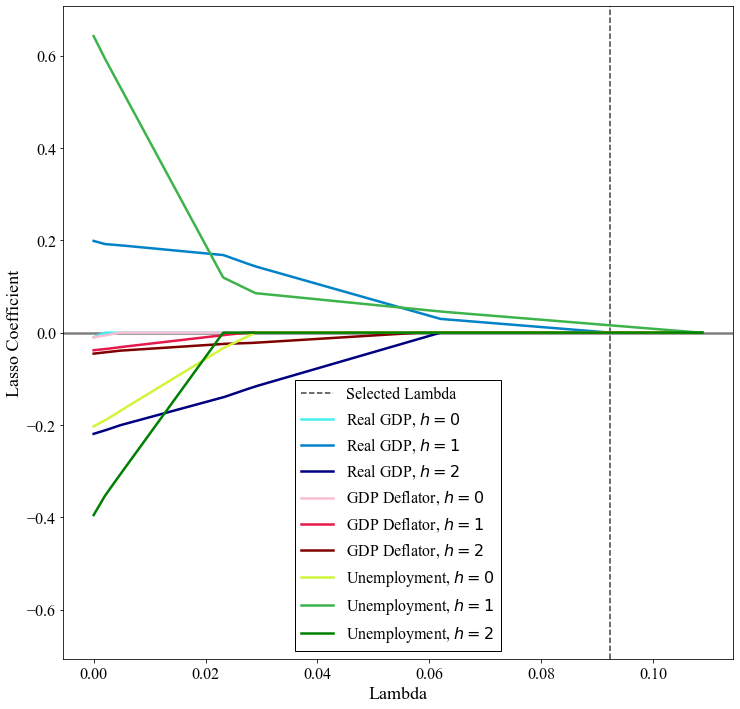

In [41]:
## Set Font ##

matplotlib.rc("font", family = "Times New Roman") # This is part of the Computer Modern family


## Get Distinct Colours ##

distinct_colours = [
    
    (0.274509803921569, 0.941176470588235, 0.941176470588235), # Cyan
    (0, 0.509803921568627, 0.784313725490196), # Blue
    (0, 0, 0.501960784313725), # Navy
    (0.980392156862745, 0.745098039215686, 0.831372549019608), # Pink
    (0.901960784313726, 0.0980392156862745, 0.294117647058824), # Red
    (0.501960784313725, 0, 0), # Maroon
    (0.823529411764706, 0.96078431372549, 0.235294117647059), # Lime
    (0.235294117647059, 0.705882352941177, 0.294117647058824),  # Green
    (0, 0.501960784313725, 0) # Forest
]


## Initiate Figure ##

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12,12)) # argued into figsize is a (width, length) tuple.


## Label Axes ##

axes.set_ylabel("Lasso Coefficient", fontsize = 18)
axes.set_xlabel("Lambda", fontsize = 18)

    
## Set Y-limits ##

max_abs_value = df_twcoef[regressors].abs().max().max() # The first .max() gets the max for each column. The second gets the
                                                       #  max of thereof.
    
ymax = 1.1*max_abs_value

ymin = -1.1*max_abs_value

plt.ylim([ymin, ymax])


## Set Tick Size ##

def tickfontsize(axis, fs):

    for tick in axis.xaxis.get_major_ticks():
    
        tick.label.set_fontsize(fs)

    for tick in axis.yaxis.get_major_ticks():
    
        tick.label.set_fontsize(fs)

tickfontsize(axes, 16)
tickfontsize(axes, 16)


## 0-line ##

plt.axhline(0, color = (0.5,0.5,0.5), ls = "-", lw = 2.5)


## Line of Selected Lambda ##

plt.axvline(tw_lambda, color = (0.25, 0.25, 0.25), ls = "--", lw = 1.5, label = "Selected Lambda")


## Plots ##

colour_iterand = 0

for regressor in regressors:
    
    if regressor[0:4] == "rgdp":
        
        r_label = "Real GDP, $\it{h = " + regressor[-1] + "}$"
        
        axes.plot(df_twcoef["lambda"], df_twcoef[regressor], color = distinct_colours[colour_iterand], lw = 2.5, label = r_label)
    
    elif regressor[0:4] == "pgdp":
    
        r_label = "GDP Deflator, $\it{h = " + regressor[-1] + "}$"
        
        axes.plot(df_twcoef["lambda"], df_twcoef[regressor], color = distinct_colours[colour_iterand], lw = 2.5, label = r_label)
        
    else:
        
        r_label = "Unemployment, $\it{h = " + regressor[-1] + "}$"
        
        axes.plot(df_twcoef["lambda"], df_twcoef[regressor], color = distinct_colours[colour_iterand], lw = 2.5, label = r_label)
    
    colour_iterand = colour_iterand + 1
    

## Add Legend ##

axes.legend(loc = 'lower center', fancybox = False, edgecolor = (0,0,0), framealpha = 1, fontsize = 16)


## Save Figure ##

plt.savefig(out_dir + "graphics\\" + "tw_lasso.jpg", dpi = 300, bbox_inches='tight')

plt.show()

### Plot Lasso Ridge for Wide Window

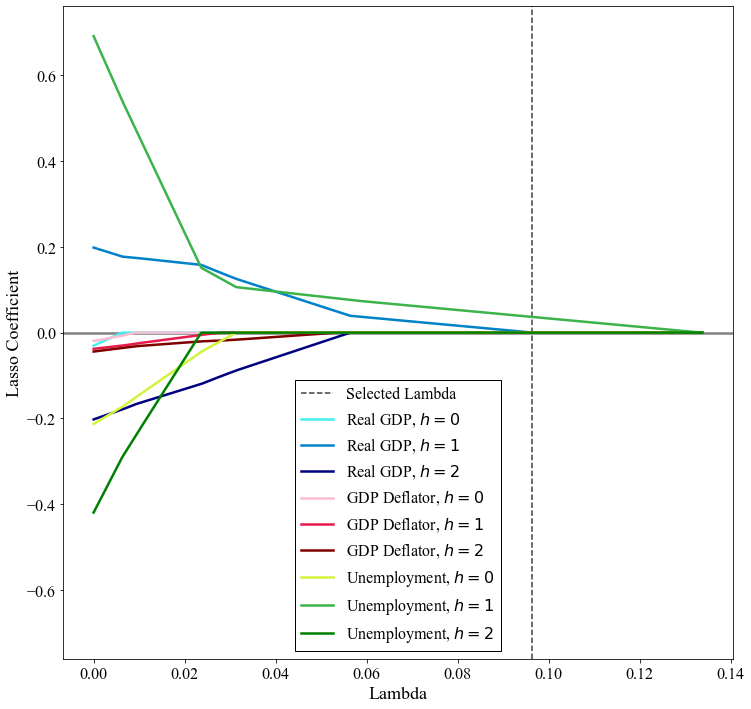

In [42]:
## Set Font ##

matplotlib.rc("font", family = "Times New Roman") # This is part of the Computer Modern family


## Get Distinct Colours ##

distinct_colours = [
    
    (0.274509803921569, 0.941176470588235, 0.941176470588235), # Cyan
    (0, 0.509803921568627, 0.784313725490196), # Blue
    (0, 0, 0.501960784313725), # Navy
    (0.980392156862745, 0.745098039215686, 0.831372549019608), # Pink
    (0.901960784313726, 0.0980392156862745, 0.294117647058824), # Red
    (0.501960784313725, 0, 0), # Maroon
    (0.823529411764706, 0.96078431372549, 0.235294117647059), # Lime
    (0.235294117647059, 0.705882352941177, 0.294117647058824),  # Green
    (0, 0.501960784313725, 0) # Forest
]


## Initiate Figure ##

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12,12)) # argued into figsize is a (width, length) tuple.


## Label Axes ##

axes.set_ylabel("Lasso Coefficient", fontsize = 18)
axes.set_xlabel("Lambda", fontsize = 18)

    
## Set Y-limits ##

max_abs_value = df_wwcoef[regressors].abs().max().max() # The first .max() gets the max for each column. The second gets the
                                                       #  max of thereof.
    
ymax = 1.1*max_abs_value

ymin = -1.1*max_abs_value

plt.ylim([ymin, ymax])


## Set Tick Size ##

def tickfontsize(axis, fs):

    for tick in axis.xaxis.get_major_ticks():
    
        tick.label.set_fontsize(fs)

    for tick in axis.yaxis.get_major_ticks():
    
        tick.label.set_fontsize(fs)

tickfontsize(axes, 16)
tickfontsize(axes, 16)


## 0-line ##

plt.axhline(0, color = (0.5,0.5,0.5), ls = "-", lw = 2.5)


## Line of Selected Lambda ##

plt.axvline(ww_lambda, color = (0.25, 0.25, 0.25), ls = "--", lw = 1.5, label = "Selected Lambda")


## Plots ##

colour_iterand = 0

for regressor in regressors:
    
    if regressor[0:4] == "rgdp":
        
        r_label = "Real GDP, $\it{h = " + regressor[-1] + "}$"
        
        axes.plot(df_wwcoef["lambda"], df_wwcoef[regressor], color = distinct_colours[colour_iterand], lw = 2.5, label = r_label)
    
    elif regressor[0:4] == "pgdp":
    
        r_label = "GDP Deflator, $\it{h = " + regressor[-1] + "}$"
        
        axes.plot(df_wwcoef["lambda"], df_wwcoef[regressor], color = distinct_colours[colour_iterand], lw = 2.5, label = r_label)
        
    else:
        
        r_label = "Unemployment, $\it{h = " + regressor[-1] + "}$"
        
        axes.plot(df_wwcoef["lambda"], df_wwcoef[regressor], color = distinct_colours[colour_iterand], lw = 2.5, label = r_label)
    
    colour_iterand = colour_iterand + 1
    

## Add Legend ##

axes.legend(loc = 'lower center', fancybox = False, edgecolor = (0,0,0), framealpha = 1, fontsize = 16)


## Save Figure ##

plt.savefig(out_dir + "graphics\\" + "ww_lasso.jpg", dpi = 300, bbox_inches='tight')

plt.show()

### Plot Lasso Ridge for Nakamura-Steinsson Series

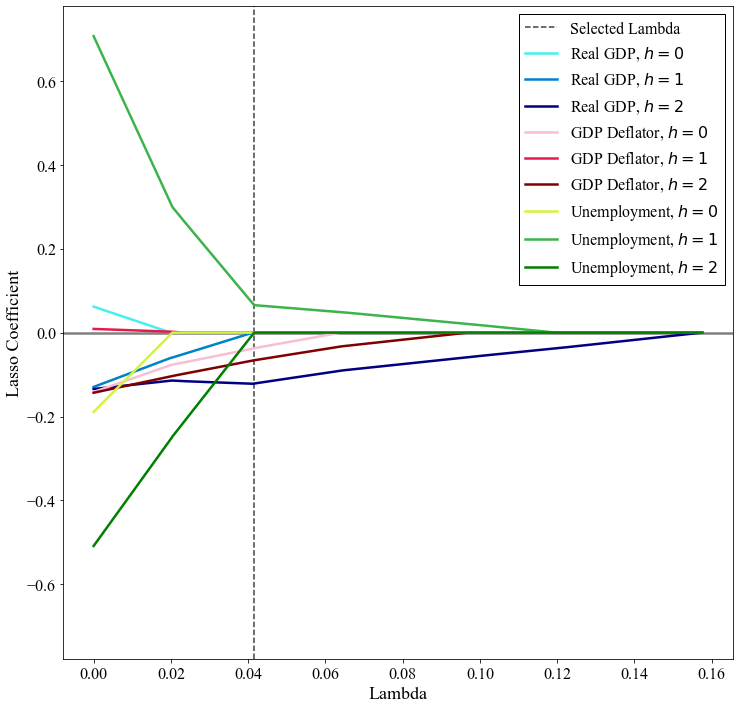

In [43]:
## Set Font ##

matplotlib.rc("font", family = "Times New Roman") # This is part of the Computer Modern family


## Get Distinct Colours ##

distinct_colours = [
    
    (0.274509803921569, 0.941176470588235, 0.941176470588235), # Cyan
    (0, 0.509803921568627, 0.784313725490196), # Blue
    (0, 0, 0.501960784313725), # Navy
    (0.980392156862745, 0.745098039215686, 0.831372549019608), # Pink
    (0.901960784313726, 0.0980392156862745, 0.294117647058824), # Red
    (0.501960784313725, 0, 0), # Maroon
    (0.823529411764706, 0.96078431372549, 0.235294117647059), # Lime
    (0.235294117647059, 0.705882352941177, 0.294117647058824),  # Green
    (0, 0.501960784313725, 0) # Forest
]


## Initiate Figure ##

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12,12)) # argued into figsize is a (width, length) tuple.


## Label Axes ##

axes.set_ylabel("Lasso Coefficient", fontsize = 18)
axes.set_xlabel("Lambda", fontsize = 18)

    
## Set Y-limits ##

max_abs_value = df_nscoef[regressors].abs().max().max() # The first .max() gets the max for each column. The second gets the
                                                       #  max of thereof.
    
ymax = 1.1*max_abs_value

ymin = -1.1*max_abs_value

plt.ylim([ymin, ymax])


## Set Tick Size ##

def tickfontsize(axis, fs):

    for tick in axis.xaxis.get_major_ticks():
    
        tick.label.set_fontsize(fs)

    for tick in axis.yaxis.get_major_ticks():
    
        tick.label.set_fontsize(fs)

tickfontsize(axes, 16)
tickfontsize(axes, 16)


## 0-line ##

plt.axhline(0, color = (0.5,0.5,0.5), ls = "-", lw = 2.5)


## Line of Selected Lambda ##

plt.axvline(ns_lambda, color = (0.25, 0.25, 0.25), ls = "--", lw = 1.5, label = "Selected Lambda")


## Plots ##

colour_iterand = 0

for regressor in regressors:
    
    if regressor[0:4] == "rgdp":
        
        r_label = "Real GDP, $\it{h = " + regressor[-1] + "}$"
        
        axes.plot(df_nscoef["lambda"], df_nscoef[regressor], color = distinct_colours[colour_iterand], lw = 2.5, label = r_label)
    
    elif regressor[0:4] == "pgdp":
    
        r_label = "GDP Deflator, $\it{h = " + regressor[-1] + "}$"
        
        axes.plot(df_nscoef["lambda"], df_nscoef[regressor], color = distinct_colours[colour_iterand], lw = 2.5, label = r_label)
        
    else:
        
        r_label = "Unemployment, $\it{h = " + regressor[-1] + "}$"
        
        axes.plot(df_nscoef["lambda"], df_nscoef[regressor], color = distinct_colours[colour_iterand], lw = 2.5, label = r_label)
    
    colour_iterand = colour_iterand + 1
    

## Add Legend ##

axes.legend(loc = 'upper right', fancybox = False, edgecolor = (0,0,0), framealpha = 1, fontsize = 16)


## Save Figure ##

plt.savefig(out_dir + "graphics\\" + "ns_lasso.jpg", dpi = 300, bbox_inches='tight')

plt.show()

### Getting the Series of Purged FFR Shocks, Correlations of All Series

In [44]:
## Purged Series ##

ytw_cbia = np.matmul(xtw_scaled, np.transpose(df_twcoef_specific[df_twcoef_specific["lambda"] == tw_lambda][regressors]))[0]

twma = ytw - ytw_cbia

yww_cbia = np.matmul(xww_scaled, np.transpose(df_wwcoef_specific[df_wwcoef_specific["lambda"] == ww_lambda][regressors]))[0]

wwma = yww - yww_cbia

yns_cbia = np.matmul(xns_scaled, np.transpose(df_nscoef_specific[df_nscoef_specific["lambda"] == ns_lambda][regressors]))[0]

nsma = yns - yns_cbia


## Get Corresponding Dates ##

twma_dates = df_ffs_full[~df_ffs_full["unexp_tw"].isna()]["date"]

wwma_dates = df_ffs_full[~df_ffs_full["unexp_ww"].isna()]["date"]

nsma_dates = df_ffs_truegb[~df_ffs_truegb["ns_shock"].isna()]["date"]


## Combine into Separate Dataframes ##

df_twma = pd.DataFrame()

df_twma["date"] = twma_dates

df_twma["twma"] = np.asarray(twma, dtype = float)

df_twma["tw_cbia"] = np.asarray(ytw_cbia, dtype = float)

df_wwma = pd.DataFrame()

df_wwma["date"] = wwma_dates

df_wwma["wwma"] = np.asarray(wwma, dtype = float)

df_wwma["ww_cbia"] = np.asarray(yww_cbia, dtype = float)

df_nsma = pd.DataFrame()

df_nsma["date"] = nsma_dates

df_nsma["nsma"] = np.asarray(nsma, dtype = float)

df_nsma["ns_cbia"] = np.asarray(yns_cbia, dtype = float)


## Combine into Single Dataframe ##

df_ma = df_twma.merge(df_wwma, on = "date", how = "outer")

df_ma = df_ma.merge(df_nsma, on = "date", how = "outer")


## Merge to Main Shocks DataFrame ##

df_ffs = df_ffs.merge(df_ma, on = "date", how = "outer")

C:\Users\Ollie\AppData\Local\Temp/ipykernel_3180/324813529.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  ytw_cbia = np.matmul(xtw_scaled, np.transpose(df_twcoef_specific[df_twcoef_specific["lambda"] == tw_lambda][regressors]))[0]
C:\Users\Ollie\AppData\Local\Temp/ipykernel_3180/324813529.py:7: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Seri

### Get Robustness Series of FFR Shocks Using OLS and BIC-selected Specification

In [45]:
## Get OLS-BIC Specifications ##

tw_olsbic_regressors = ["unemp_1", "unemp_2"]

ns_olsbic_regressors = ["rgdp_2"]


## Fit Models ##

model_tw = sm.OLS(np.asarray(ytw, dtype = float), 
                  np.asarray(xtw_scaled[tw_olsbic_regressors], dtype = float)).fit()

model_ns = sm.OLS(np.asarray(yns, dtype = float), 
                  np.asarray(xns_scaled[ns_olsbic_regressors], dtype = float)).fit()


## Get Residuals ##

twma_bic = model_tw.resid

nsma_bic = model_ns.resid


## Get Corresponding Dates ##

twma_dates = df_ffs_full[~df_ffs_full["unexp_tw"].isna()]["date"]

nsma_dates = df_ffs_truegb[~df_ffs_truegb["ns_shock"].isna()]["date"]


## Combine into Separate Dataframes ##

df_twma_bic = pd.DataFrame()

df_twma_bic["date"] = twma_dates

df_twma_bic["twma_bic"] = np.asarray(twma_bic, dtype = float)

df_nsma_bic = pd.DataFrame()

df_nsma_bic["date"] = nsma_dates

df_nsma_bic["nsma_bic"] = np.asarray(nsma_bic, dtype = float)


## Combine into Single Dataframe ##

df_ma_bic = df_twma_bic.merge(df_nsma_bic, on = "date", how = "outer")


## Merge to Main Shocks DataFrame ##

df_ffs = df_ffs.merge(df_ma_bic, on = "date", how = "outer")

### Summarise BIC-Selected Specifications

In [46]:
print(model_tw.summary())

print(model_ns.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.042
Model:                            OLS   Adj. R-squared (uncentered):              0.031
Method:                 Least Squares   F-statistic:                              3.968
Date:                Mon, 30 May 2022   Prob (F-statistic):                      0.0206
Time:                        14:43:22   Log-Likelihood:                         -238.40
No. Observations:                 183   AIC:                                      480.8
Df Residuals:                     181   BIC:                                      487.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Get Correlations Among Shock Series

In [865]:
# Initiations #

series = ["unexp_tw","twma","unexp_ww","wwma","ns_shock","nsma","twma_bic","nsma_bic"]

for ser1 in series:
    
    print(ser1 + " has " + str(len(df_ffs[(~df_ffs[ser1].isna())].index)) + " observations.")

iterand = 1

print(" ")
       
for ser1 in series:
    
    if iterand == 6: continue
        
    for ser2 in series[iterand:]:
        
        print(ser1 + " and " + ser2 + " have " + str(len(df_ffs[(~df_ffs[ser1].isna())*(~df_ffs[ser2].isna())])) + " common observations.")
    
    iterand = iterand + 1
    
df_ffs[series].corr()

unexp_tw has 183 observations.
twma has 183 observations.
unexp_ww has 183 observations.
wwma has 183 observations.
ns_shock has 151 observations.
nsma has 128 observations.
twma_bic has 183 observations.
nsma_bic has 128 observations.
 
unexp_tw and twma have 183 common observations.
unexp_tw and unexp_ww have 183 common observations.
unexp_tw and wwma have 183 common observations.
unexp_tw and ns_shock have 72 common observations.
unexp_tw and nsma have 72 common observations.
unexp_tw and twma_bic have 183 common observations.
unexp_tw and nsma_bic have 72 common observations.
twma and unexp_ww have 183 common observations.
twma and wwma have 183 common observations.
twma and ns_shock have 72 common observations.
twma and nsma have 72 common observations.
twma and twma_bic have 183 common observations.
twma and nsma_bic have 72 common observations.
unexp_ww and wwma have 183 common observations.
unexp_ww and ns_shock have 72 common observations.
unexp_ww and nsma have 72 common obse

,unexp_tw,twma,unexp_ww,wwma,ns_shock,nsma,twma_bic,nsma_bic
unexp_tw,1.000000,0.999837,0.987933,0.988112,0.573586,0.571779,0.977570,0.570529
twma,0.999837,1.000000,0.987279,0.988192,0.571752,0.571362,0.979593,0.568580
unexp_ww,0.987933,0.987279,1.000000,0.999174,0.563621,0.561424,0.962337,0.559294
wwma,0.988112,0.988192,0.999174,1.000000,0.558352,0.559451,0.967418,0.553763
ns_shock,0.573586,0.571752,0.563621,0.558352,1.000000,0.986930,0.518974,0.985638
nsma,0.571779,0.571362,0.561424,0.559451,0.986930,1.000000,0.524018,0.993445
twma_bic,0.977570,0.979593,0.962337,0.967418,0.518974,0.524018,1.000000,0.515073
nsma_bic,0.570529,0.568580,0.559294,0.553763,0.985638,0.993445,0.515073,1.000000


### Add 0s to Missing Shocks

To facilitate the below, we add 0s to all series where values are missing. This produces zero values for shocks inapplicable to particular series.

In [866]:
df_ffs = df_ffs.fillna(0)

### Getting Idiosyncratic Quarter Monetary Policy (FFR) Shocks: Gertler and Karadi (2015)

Here we loop through each firm-quarter observations in the Compustat data and calculate the implied monetary policy shock for that firm-quarter following Gertler & Karadi (2015).

**Methodology**

- Denote the firm-quarter by $Q_{ti}$, with $t$ giving the fiscal quarter (i.e. 1990Q1) and $i$ giving the firm with its idiosyncratic fiscal quarter endpoints. 

- Each firm-quarter contains FOMC meeting monetary policy shocks $s_{tij}$, as given in **001a_ffsurprises_tctime.dta**.

- The proportion of firm-quarter $Q_{ti}$ that has elapsed when shock $s_{tij}$ occurs is given by $\alpha_{tij}$.

The firm-quarter monetary policy shock $\gamma_{ti}^{GK}$ is then given by...

$$
\gamma_{ti}^{GK} = \underbrace{\sum_{s_{t-1,ij} \in Q_{t-1,i}} \alpha_{t-1,ij}s_{t-1,ij}}_{\text{weighted shocks from previous quarter}} + \underbrace{\sum_{s_{tij} \in Q_{ti}} (1 - \alpha_{tij})s_{tij}}_{\text{weighted shocks from current quarter}}
$$

**New Variables: Compustat Dataframe (`df_cstat`)**
- **tw_shock_gk**: The firm-quarter monetary policy shock constructed as above using "tight window" FOMC post-meeting statement shocks. Missing for all firm-quarters starting before 00:00:00 1st March 1990 or starting after 00:00:00 1st January 2010.
- **ww_shock_gk**: The firm-quarter monetary policy shock constructed as above using "wide window" FOMC post-meeting statement shocks. Missing for all firm-quarters starting before 00:00:00 1st March 1990 or starting after 00:00:00 1st January 2010.
- **ns_shock_gk**: The firm-quarter monetary policy shock constructed as above using Nakamura and Steinsson (2018) shocks as extended by Acosta and Saia (Forthcoming). Missing for all firm-quarters starting before 00:00:00 1st March 2000, starting after 00:00:00 1st January 2020, or covering any amount of time within 00:00:00 1st of August 2008 through 00:00:00 1st of August 2009.
- **tw_ma_shock_gk**: The firm-quarter monetary policy shock constructed as above using "tight window" FOMC post-meeting statement shocks, subjected to purging of the Fed Information Effect following Miranda-Aggripino (2017). Missing for all firm-quarters starting before 00:00:00, 1st March 1990 or starting after 00:00:00
- **ww_ma_shock_gk**: The firm-quarter monetary policy shock constructed as above using "wide window" FOMC post-meeting statement shocks, subjected to purging of the Fed Information Effect following Miranda-Aggripino (2017). Missing for all firm-quarters starting before 00:00:00 1st March 1990 or starting after 00:00:00 1st January 2010.
- **ns_ma_shock_gk**: The firm-quarter monetary policy shock constructed as above using Nakamura and Steinsson (2018) shocks as extended by Acosta and Saia (Forthcoming), subjected to purging of the Fed Information Effect following Miranda-Aggripino (2017). Missing for all firm-quarters starting before 00:00:00 1st March 2000, starting after 00:00:00 1st January 2020, or covering any amount of time within 00:00:00 1st of August 2008 through 00:00:00 1st of August 2009.

In [867]:
########################
# PRE-LOOP INITIATIONS #
########################

tw_shocks = [] # Initiate list of "tight window" quarter shocks.

ww_shocks = [] # Initiate list of "wide window" quarter shocks.

ns_shocks = [] # Initiate list of Nakamura and Steinsson (2018) quarter shocks.

tw_ma_shocks = []

ww_ma_shocks = []

ns_ma_shocks = []

tw_ma_bic_shocks = []

ns_ma_bic_shocks = []

tc_1990 = 946769400000 # 23:30:00 31st December 1989, milliseconds since start of 1960. Serves as coverage lower bound 
                      # for start of previous quarter. 30 minute leeway given to account for truncation errors.

tc_oct2019 = 1885509000000 # 00:30:00 1st October 2019, milliseconds since start of 1960. Serves as coverage upper bound
                          # for end of current quarter. 30 minute leeway given to account for truncation errors.


########
# LOOP #
########

for i in df_cstat.index: # Loop through each quarter
    
    ## Check whole quarter and previous covered by shock series ##
    
    cur_q_end = df_cstat.at[i, "tc_current_q_end"] # Current quarter end, milliseconds since start of 1960
    
    pre_q_start = df_cstat.at[i, "tc_lag2_q_end"] # Previous quarter start 
    
    if pre_q_start < tc_1990 or cur_q_end > tc_oct2019: # We can't calculate shocks for these quarters
        
        tw_shocks.append(None) # Will register as NaN in Pandas
        
        ww_shocks.append(None)
        
        ns_shocks.append(None)
        
        tw_ma_shocks.append(None)
        
        ww_ma_shocks.append(None)
        
        ns_ma_shocks.append(None)
        
        tw_ma_bic_shocks.append(None)
        
        ns_ma_bic_shocks.append(None)
        
        continue
    
    ## Initiate quarter Variables ##
    
    tw_shock = 0 # Initiate tight window shock
    
    ww_shock = 0 # Initiate wide window shock
    
    ns_shock = 0 
    
    tw_ma_shock = 0 # Initiate tight window Miranda-Agrippino "formal" shock
    
    ww_ma_shock = 0 # Initiate wide window Miranda-Agrippino "formal" shock
    
    ns_ma_shock = 0
    
    tw_ma_bic_shock = 0
    
    ns_ma_bic_shock = 0
    
    cur_q_start = df_cstat.at[i, "tc_lag1_q_end"] # Current quarter start, milliseconds since start of 1960
    
    pre_q_end = df_cstat.at[i, "tc_lag1_q_end"] # Same variable. Just want nominal clarity here.
    
    cur_q_len = cur_q_end - cur_q_start # Length of current quarter, milliseconds
    
    pre_q_len = pre_q_end - pre_q_start # Length of previous quarter, milliseconds
    
    
    ## Current Quarter FOMC Meeting Shocks ##
    
    cur_q_fomcshocks = df_ffs[(df_ffs["tc_time"] > cur_q_start) & (df_ffs["tc_time"] < cur_q_end)]
    
    for j in cur_q_fomcshocks.index: # Loop through FOMC meeting shocks in current quarter
        
        alpha = (cur_q_fomcshocks.at[j,"tc_time"] - cur_q_start)/cur_q_len # Proportion of quater elapsed
        
        tw_shock = tw_shock + (1 - alpha)*cur_q_fomcshocks.at[j,"unexp_tw"] # Add to tight-window shock
        
        ww_shock = ww_shock + (1 - alpha)*cur_q_fomcshocks.at[j,"unexp_ww"] # Add tp wide-window shock
        
        ns_shock = ns_shock + (1 - alpha)*cur_q_fomcshocks.at[j,"ns_shock"]
        
        tw_ma_shock = tw_ma_shock + (1 - alpha)*cur_q_fomcshocks.at[j,"twma"]
        
        ww_ma_shock = ww_ma_shock + (1 - alpha)*cur_q_fomcshocks.at[j,"wwma"]
        
        ns_ma_shock = ns_ma_shock + (1 - alpha)*cur_q_fomcshocks.at[j,"nsma"]
    
        tw_ma_bic_shock = tw_ma_bic_shock + (1 - alpha)*cur_q_fomcshocks.at[j,"twma_bic"]

        ns_ma_bic_shock = ns_ma_bic_shock + (1 - alpha)*cur_q_fomcshocks.at[j,"nsma_bic"]
    
    ## Previous Quarter FOMC Meeting Shocks ##
    
    pre_q_fomcshocks = df_ffs[(df_ffs["tc_time"] > pre_q_start) & (df_ffs["tc_time"] < pre_q_end)]
    
    for j in pre_q_fomcshocks.index: # Loop through FOMC meeting shocks in previous quarter
        
        alpha = (pre_q_fomcshocks.at[j,"tc_time"] - pre_q_start)/pre_q_len
        
        tw_shock = tw_shock + alpha*pre_q_fomcshocks.at[j,"unexp_tw"] # Add to tight-window shock
        
        ww_shock = ww_shock + alpha*pre_q_fomcshocks.at[j,"unexp_ww"] # Add tp wide-window shock
        
        ns_shock = ns_shock + alpha*pre_q_fomcshocks.at[j,"ns_shock"]
        
        tw_ma_shock = tw_ma_shock + alpha*pre_q_fomcshocks.at[j,"twma"]
        
        ww_ma_shock = ww_ma_shock + alpha*pre_q_fomcshocks.at[j,"wwma"]
        
        ns_ma_shock = ns_ma_shock + alpha*pre_q_fomcshocks.at[j,"nsma"]
        
        tw_ma_bic_shock = tw_ma_bic_shock + alpha*pre_q_fomcshocks.at[j,"twma_bic"]
        
        ns_ma_bic_shock = ns_ma_bic_shock + alpha*pre_q_fomcshocks.at[j,"nsma_bic"]
        
    
    ## Append to Shock Lists ##
    
    tw_shocks.append(tw_shock)
    
    ww_shocks.append(ww_shock)
    
    ns_shocks.append(ns_shock)

    tw_ma_shocks.append(tw_ma_shock)

    ww_ma_shocks.append(ww_ma_shock)
    
    ns_ma_shocks.append(ns_ma_shock)
        
    tw_ma_bic_shocks.append(tw_ma_bic_shock)

    ns_ma_bic_shocks.append(ns_ma_bic_shock)
    
    
#################################
# APPEND TO COMPUSTAT DATAFRAME #
#################################

df_cstat["tw_shock_gk"] = tw_shocks

df_cstat["ww_shock_gk"] = ww_shocks

df_cstat["ns_shock_gk"] = ns_shocks

df_cstat["tw_ma_shock_gk"] = tw_ma_shocks

df_cstat["ww_ma_shock_gk"] = ww_ma_shocks

df_cstat["ns_ma_shock_gk"] = ns_ma_shocks

df_cstat["tw_ma_bic_shock_gk"] = tw_ma_bic_shocks

df_cstat["ns_ma_bic_shock_gk"] = ns_ma_bic_shocks

### Getting Idiosyncratic Quarter Monetary Policy Shocks: Wong (2021)

Here we loop through each firm-quarter observations in the Compustat data and calculate the implied monetary policy shock for that firm-quarter following Wong (2021).

**Methodology**

- Denote the firm-quarter by $Q_{ti}$, with $t$ giving the fiscal quarter (i.e. 1990Q1) and $i$ giving the firm with its idiosyncratic fiscal quarter endpoints. 

- Each firm-quarter contains FOMC meeting monetary policy shocks $s_{tij}$, as given in **001a_ffsurprises_tctime.dta**.

The firm-quarter monetary policy shock $\gamma_{ti}^{W}$ is then given by...

$$
\gamma_{ti}^{W} = \underbrace{\sum_{s_{t-1,ij} \in Q_{t-1,i}} s_{t-1,ij}}_{\text{shocks from previous quarter}}
$$

**New Variables: Compustat Dataframe (`df_cstat`)**
- **tw_shock_w**: The firm-quarter monetary policy shock constructed as above using "tight window" FOMC post-meeting statement shocks. Missing for all firm-quarters starting before 00:00:00 1st March 1990 or starting after 00:00:00 1st January 2010.
- **ww_shock_w**: The firm-quarter monetary policy shock constructed as above using "wide window" FOMC post-meeting statement shocks. Missing for all firm-quarters starting before 00:00:00 1st March 1990 or starting after 00:00:00 1st January 2010.
- **ns_shock_w**: The firm-quarter monetary policy shock constructed as above using Nakamura and Steinsson (2018) shocks as extended by Acosta and Saia (Forthcoming). Missing for all firm-quarters starting before 00:00:00 1st March 2000, starting after 00:00:00 1st January 2020, or covering any amount of time within 00:00:00 1st of August 2008 through 00:00:00 1st of August 2009.
- **tw_ma_shock_w**: The firm-quarter monetary policy shock constructed as above using "tight window" FOMC post-meeting statement shocks, subjected to purging of the Fed Information Effect following Miranda-Aggripino (2017). Missing for all firm-quarters starting before 00:00:00, 1st March 1990 or starting after 00:00:00
- **ww_ma_shock_w**: The firm-quarter monetary policy shock constructed as above using "wide window" FOMC post-meeting statement shocks, subjected to purging of the Fed Information Effect following Miranda-Aggripino (2017). Missing for all firm-quarters starting before 00:00:00 1st March 1990 or starting after 00:00:00 1st January 2010.
- **ns_ma_shock_w**: The firm-quarter monetary policy shock constructed as above using Nakamura and Steinsson (2018) shocks as extended by Acosta and Saia (Forthcoming), subjected to purging of the Fed Information Effect following Miranda-Aggripino (2017). Missing for all firm-quarters starting before 00:00:00 1st March 2000, starting after 00:00:00 1st January 2020, or covering any amount of time within 00:00:00 1st of August 2008 through 00:00:00 1st of August 2009.

In [868]:
########################
# PRE-LOOP INITIATIONS #
########################

tw_shocks = [] # Initiate list of "tight window" quarter shocks.

ww_shocks = [] # Initiate list of "wide window" quarter shocks.

ns_shocks = [] # Initiate list of Nakamura and Steinsson (2018) quarter shocks.

tw_ma_shocks = []

ww_ma_shocks = []

ns_ma_shocks = []

tw_ma_bic_shocks = []

ns_ma_bic_shocks = []

tc_1990 = 946769400000 # 23:30:00 31st December 1989, milliseconds since start of 1960. Serves as coverage lower bound 
                      # for start of current quarter. 30 minute leeway given to account for truncation errors.

tc_oct2019 = 1885509000000 # 00:30:00 1st October 2019, milliseconds since start of 1960. Serves as coverage upper bound
                          # for end of current quarter. 30 minute leeway given to account for truncation errors.

    
########
# LOOP #
########

for i in df_cstat.index: # Loop through each quarter
    
    
    ## Check previous quarter covered by shock series ##
    
    prev_q_end = df_cstat.at[i, "tc_lag1_q_end"] # Current quarter end, milliseconds since start of 1960
    
    prev_q_start = df_cstat.at[i, "tc_lag2_q_end"] # Previous quarter start 
    
    if prev_q_start < tc_1990 or prev_q_end > tc_oct2019: # We can't calculate shocks for these quarters
        
        tw_shocks.append(None) # Will register as NaN in Pandas
        
        ww_shocks.append(None)
        
        ns_shocks.append(None)
        
        tw_ma_shocks.append(None)
        
        ww_ma_shocks.append(None)
        
        ns_ma_shocks.append(None)
        
        tw_ma_bic_shocks.append(None)
        
        ns_ma_bic_shocks.append(None)
        
        continue 
    
    
    ## Initiate Quarter Variables ##
    
    tw_shock = 0 # Initiate tight window shock
    
    ww_shock = 0 # Initiate wide window shock
    
    ns_shock = 0 
    
    tw_ma_shock = 0 # Initiate tight window Miranda-Agrippino "formal" shock
    
    ww_ma_shock = 0 # Initiate wide window Miranda-Agrippino "formal" shock
    
    ns_ma_shock = 0
    
    tw_ma_bic_shock = 0
    
    ns_ma_bic_shock = 0
    
    
    ## Previous Quarter FOMC Meeting Shocks ##
    
    pre_q_fomcshocks = df_ffs[(df_ffs["tc_time"] > prev_q_start) & (df_ffs["tc_time"] < prev_q_end)]
    
    for j in pre_q_fomcshocks.index: # Loop through FOMC meeting shocks in previous quarter
        
        tw_shock = tw_shock + pre_q_fomcshocks.at[j,"unexp_tw"]
        
        ww_shock = ww_shock + pre_q_fomcshocks.at[j,"unexp_ww"]
        
        ns_shock = ns_shock + pre_q_fomcshocks.at[j,"ns_shock"]
        
        tw_ma_shock = tw_ma_shock + pre_q_fomcshocks.at[j,"twma"]
        
        ww_ma_shock = ww_ma_shock + pre_q_fomcshocks.at[j,"wwma"]
        
        ns_ma_shock = ns_ma_shock + pre_q_fomcshocks.at[j,"nsma"]
        
        tw_ma_bic_shock = tw_ma_bic_shock + pre_q_fomcshocks.at[j,"twma_bic"]
        
        ns_ma_bic_shock = ns_ma_bic_shock + pre_q_fomcshocks.at[j,"nsma_bic"]
        
    
    ## Append to Shock Lists ##
    
    tw_shocks.append(tw_shock)
    
    ww_shocks.append(ww_shock)
    
    ns_shocks.append(ns_shock)

    tw_ma_shocks.append(tw_ma_shock)

    ww_ma_shocks.append(ww_ma_shock)
    
    ns_ma_shocks.append(ns_ma_shock)
        
    tw_ma_bic_shocks.append(tw_ma_bic_shock)

    ns_ma_bic_shocks.append(ns_ma_bic_shock)
    
    
#################################
# APPEND TO COMPUSTAT DATAFRAME #
#################################

df_cstat["tw_shock_w"] = tw_shocks

df_cstat["ww_shock_w"] = ww_shocks

df_cstat["ns_shock_w"] = ns_shocks

df_cstat["tw_ma_shock_w"] = tw_ma_shocks

df_cstat["ww_ma_shock_w"] = ww_ma_shocks

df_cstat["ns_ma_shock_w"] = ns_ma_shocks

df_cstat["tw_ma_bic_shock_w"] = tw_ma_bic_shocks

df_cstat["ns_ma_bic_shock_w"] = ns_ma_bic_shocks

### Merge Back Into gvkey-datadate DataFrame

Because of the way this code was initially written, we have to merge back to each gvkey-datadate combination here in order for these results to plug back into to the remainder of the body of code.

In [869]:
## Get full gvkey-datadate dataframe ##

df_cstat_full = pd.read_stata(out_dir + "001a_cstat_qdates.dta", convert_dates = False)

## Merge in Shocks ##

df_cstat_full = df_cstat_full.merge(df_cstat,
                                    left_on = ["td_datadate", "tc_current_q_end", "tc_lag1_q_end", "tc_lag2_q_end"],
                                    right_on = ["td_datadate", "tc_current_q_end", "tc_lag1_q_end", "tc_lag2_q_end"])

### Drop Extraneous Columns, Export to *.dta*

We use **gvkey** and **datadate** (the latter is renamed as such from **td_datadate** below) as our variables to merge back into Compustat. Hence, we drop other variables.

Keeping firm-quarter observations with missing shock values only prolongs merging time, so we drop those here.

In [870]:
## Drop Extraneous Variables ##

df_cstat_export = df_cstat_full[["gvkey","td_datadate","tw_shock_gk","ww_shock_gk","ns_shock_gk","tw_shock_w","ww_shock_w",
                                 "ns_shock_w","tw_ma_shock_gk","ww_ma_shock_gk","ns_ma_shock_gk", "tw_ma_shock_w",
                                 "ww_ma_shock_w","ns_ma_shock_w","tw_ma_bic_shock_gk","ns_ma_bic_shock_gk",
                                 "tw_ma_bic_shock_w","ns_ma_bic_shock_w"]]

## Rename td_datadate_adj to datadate_adj ##

df_cstat_export = df_cstat_export.rename(columns = {"td_datadate":"datadate"})

## Set gvkey-td_datadate_adj to be Index ##

df_cstat_export = df_cstat_export.set_index(["gvkey","datadate"]) # Neither variable uniquely identifies observations,
                                                                 # so we use them in tandem.

## Drop Observations with Missing Shock Values ##

df_cstat_export = df_cstat_export.dropna()


## Export ##

df_cstat_export.to_stata(out_dir + "001b_cstat_shocks.dta")

## Calculating "Exact Quarter" Federal Funds Rate Target

Here we want the federal funds rate at the *end* of each "exact calendar quarter", the structure of each of which is laid out below under **Calculating "Exact Quarter" BLS Implicit Price Deflator**.

Sources...
- (1989Q4b-2008Q4a) https://fred.stlouisfed.org/series/DFEDTAR
- (2008Q4b-2021Q4b; Lower Bound) https://fred.stlouisfed.org/series/DFEDTARL
- (2008Q4b-2021Q4b; Upper Bound) https://fred.stlouisfed.org/series/DFEDTARU

### Import FFR Target Data

In [108]:
df_target = pd.read_excel(in_dir + "data\\ffr_target.xlsx")

### Build Dataframe of FFR Targets at the End of each Exact Calendar Quarter

Since our FFR target data is wider than necessary and enables us to build 1982Q3b-2022Q1c data, that's exactly what we do.

In [109]:
## Initiations ##

ecq_endmonths = range(272,748) # We use January 1960 as month 0 here.

letters = ["a","b","c"] # Letters for the end of the exact calendar quarter string

df_target_ecq = pd.DataFrame(columns = ["ecq","ffr_target"])


## Loop Through Exact Calendar Quarters, by End Month ##

for ecq_endmonth in ecq_endmonths:
    
    
    ## Get Time Data ##
    
    cal_year = int(np.floor(ecq_endmonth/12) + 1960) # Calendar Year
    
    month_in_year = (ecq_endmonth % 12) + 1 # Month *within* year. 1-12.
    
    first_day_pd = pd.Timestamp(str(cal_year) + "-" + str(month_in_year) + "-01") # First day of month as timestamp
    
    last_day_pd = (first_day_pd + pd.DateOffset(months = 1)) - pd.Timedelta(1, unit = "days") # Last day of month as 
                                                                                             # timestamp
    
    ## Get FFR Target at end of Exact Calendar Quarter ##
    
    ffr_target = df_target[df_target["date"] == last_day_pd]["ffr_target"].values[0]
    
    
    ## Get Exact Calendar Quarter String ##
    
    ecq_year = cal_year - (month_in_year == 1) # Pushes Januaries back by a year
    
    ecq_q = int(np.floor(((month_in_year - 2) % 12)/3)) + 1 # Maps to each of four quarters
    
    ecq_letter_index = (month_in_year + 1) % 3 # Maps to "a", "b", or "c"
    
    ecq_letter = letters[ecq_letter_index]
    
    ecq = str(ecq_year) + "Q" + str(ecq_q) + ecq_letter
    
    
    ## Append Row to Dataframe ##
    
    df_target_ecq = df_target_ecq.append({"ecq":ecq, "ffr_target":ffr_target}, ignore_index = True)

### Export to *.dta*

In [110]:
df_target_ecq.set_index("ecq", inplace = True) # Setting index prevents Stata from inheriting the arbitrary index here.

df_target_ecq["ffr_target"] = df_target_ecq["ffr_target"]/100 # Change base from 100 to 1

df_target_ecq.to_stata(out_dir + "001b_ecq_ffr.dta")

## Calculating "Exact Quarter" BLS Implicit Price Deflator

Since firm financial quarters do not always cover the calendar quarters covered by the Bureau of Labor Statistics' Implicit Price Deflator, here I name exact calendar quarters as follows...

- Dec (previous year) to Feb: **Q1a**
- Jan to Mar: **Q1b**
- Feb to Apr: **Q1c**

- Mar to May: **Q2a**
- Apr to Jun: **Q2b**
- May to Jul: **Q2c**

- Jun to Aug: **Q3a**
- Jul to Sep: **Q3b**
- Aug to Oct: **Q3c**

- Sep to Nov: **Q4a**
- Oct to Dec: **Q4b**
- Nov to Jan (following year): **Q4c**

...and calculate their corresponding BLS Implicit Price Deflator as follows: Let $P_{y,q}^{BLS}$ give the BLS implicit price deflator for quarter $q$ of year $y$, and let $P_{0,q\gamma}$ give the Implicit Price Deflator corresponding to quarter **Q$q\gamma$** for year 0 as defined above. Then...

$$ 
\begin{aligned}
&P_{0,qa} = \begin{cases} \frac{1}{3} \cdot P_{-1,4}^{BLS} + \frac{2}{3} \cdot P_{0,1}^{BLS}~~~~\text{if}~q=1 \\ \frac{1}{3} \cdot P_{0,q-1}^{BLS} + \frac{2}{3} \cdot P_{0,q}^{BLS}~~~~\text{if}~q > 1, \end{cases} \\ ~ \\
&P_{0,qb} = P_{0,q}^{BLS}, \\ ~ \\
&P_{0,qc} = \begin{cases} \frac{2}{3} \cdot P_{0,q}^{BLS} + \frac{1}{3} \cdot P_{0,q+1}^{BLS}~~~~\text{if}~q<4 \\ \frac{2}{3} \cdot P_{0,4}^{BLS} + \frac{1}{3} \cdot P_{1,1}^{BLS}~~~~\text{if}~q = 4. \end{cases}
\end{aligned}
$$

### Import BLS Implicit Price Deflator Data

In [111]:
df_ipd_bls = pd.read_excel(in_dir + "data\\bls_ipd_1947Q1_2021Q3.xlsx")

### Build DataFrame for "Exact Calendar Quarter" Implicit Price Deflator Values

This code depends on the BLS data starting at 1947Q1.

In [112]:
########################
# PRE-LOOP INITIATIONS #
########################

bls_obs = len(df_ipd_bls.index) # The number of BLS Observations we have.

letters = ["a","b","c"] # The letters that will suffix the quarters, which will be of the form "1960Q1a".

df_ipd_ecq = pd.DataFrame(columns = ["ecq","ipd"]) # DataFrame containg exact calendar quarter IPDs

year = 1947 # year in which we start

########
# LOOP #
########

for i in range(1,bls_obs*3 - 1): # We have three times the number of BLS observations minus one to construct.
    
    main_bls_index = int(np.floor(i/3)) # Maps from i to the index of the BLS quarter which constitutes most of the 
                                       # exact calendar quarter
    
    l1_q = int(np.floor((i % 12)/3)) + 1 # Maps from i to the "level-one quarter" (i.e. 1, 2, 3, or 4).
        
    
    if i % 3 == 0: # Quarters with the -a suffix
        
        if i % 12 == 0: # Special case of i % 3 = 0
        
            year = year + 1 # December marks the start of a new year here, so we update.
        
        ecq_string = str(year) + "Q" + str(l1_q) + "a" # Exact calendar quarter name
        
        ipd = (1/3)*df_ipd_bls.at[main_bls_index - 1, "IPDBS"] + (2/3)*df_ipd_bls.at[main_bls_index, "IPDBS"]
        
        df_ipd_ecq = df_ipd_ecq.append({"ecq":ecq_string, "ipd":ipd}, ignore_index = True)
        
    elif i % 3 == 1: # Quarters with the -b suffix
        
        ecq_string = str(year) + "Q" + str(l1_q) + "b"
        
        ipd = df_ipd_bls.at[main_bls_index, "IPDBS"]
        
        df_ipd_ecq = df_ipd_ecq.append({"ecq":ecq_string, "ipd":ipd}, ignore_index = True)
        
    else: # Quarters with the -c suffix
        
        ecq_string = str(year) + "Q" + str(l1_q) + "c"
        
        ipd = (2/3)*df_ipd_bls.at[main_bls_index, "IPDBS"] + (1/3)*df_ipd_bls.at[main_bls_index + 1, "IPDBS"]
        
        df_ipd_ecq = df_ipd_ecq.append({"ecq":ecq_string, "ipd":ipd}, ignore_index = True)
        
#############
# POST-LOOP #
#############

df_ipd_ecq.set_index("ecq", inplace = True) # Setting index prevents Stata from inheriting the arbitrary index here.

df_ipd_ecq["ipd"] = df_ipd_ecq["ipd"]/100 # Change base from 100 to 1

### Export to *.dta*

Here we use **ecq** as the variable to merge back to Compustat, with exact calendar quarter in the Compustat dataset calculated in script *001c_data_processing.do*

In [113]:
df_ipd_ecq.to_stata(out_dir + "001b_ecq_ipd.dta")

## Calculating "Exact Quarter" OECD Consumer Price Index

Above we obtain an exact-quarter BLS GDP Deflator using interpolation - the GDP deflator for May-July uses data from both Q2 *and* Q3. We cannot use this to calculate real values for regression controls that are supposed to be exogenous to the monetary policy shock corresponding to August-January, since both August and September are part of the Q3 GDP deflator.

Unfortunately, GDP deflators are not available at a monthly frequency. Therefore, we use CPI to deflate our regression variables. The disadvantage here is that the "real terms" in which our variables will be given will be in terms of *final* goods and services, rather than goods and services in general. This seems worth it to preserve exogeneity though.

We use the OECD's monthly index for CPI. Denote the OECD index for month $m$ of year $y$ by $p_{y,m}^{OECD}$. Using the naming convention for exact calendar quarters given above and denoting the index for quarter $q\gamma$ of year $y$ by $p_{y,q\gamma}$, we have, for example...

$$
p_{0,4c} = \frac{p_{0,11}^{OECD} + p_{0,12}^{OECD} + p_{1,1}^{OECD}}{3}
$$

We also, as a macroeconomic control variable, calculate net quarter-on-quarter annualised inflation. Denoting by $\pi_{y,q\gamma}$ this figure for quarter $q\gamma$ of year $y$, we have, for example... 

$$
\pi_{0,4c} = \left(\frac{p_{0,4c}}{p_{0,3c}}\right)^4 - 1
$$


### Import OECD CPI Data

In [28]:
df_oecd_cpi = pd.read_excel(in_dir + "data\\oecd_cpi_jan1960_feb2022.xlsx", index_col = "observation_date")

### Build DataFrame for "Exact Calendar Quarter" OECD CPI

In [20]:
########################
# PRE-LOOP INITIATIONS #
########################

oecd_dates = df_oecd_cpi.index[:-2] # The *first* month of the exact calendar quarter for which we can
                                                 # calculate a CPI

letters = ["a","b","c"] # The letters that will suffix the quarters, which will be of the form "1960Q1a".

df_cpi_ecq = pd.DataFrame(columns = ["ecq","cpi","cpi_inflation"]) # DataFrame containg exact calendar quarter price indices

########
# LOOP #
########

for date in oecd_dates:
    
    ## Get Exact Calendar Quarter String ##
    
    year = date.year # Year of first month in exact calendar quarter
    
    month = date.month # 1-12. First month in exact calendar quarter
    
    ecq_year = year + (month == 12) # Year of the exact calendar quarter 
    
    ecq_super_quarter = int(np.floor((month % 12)/3) + 1)
    
    ecq_letter_index = month % 3 # index of the correct item of "letters"
    
    ecq_letter = letters[ecq_letter_index] # Letter of the exact calendar quarter
    
    ecq = str(ecq_year) + "Q" + str(ecq_super_quarter) + ecq_letter # ECQ string
    
    
    ## Get CPI ##
    
    month_0 = date # First month of ecq
    
    month_1 = date + pd.DateOffset(months = 1) # Second month of ecq
    
    month_2 = date + pd.DateOffset(months = 2) # Third month of ecq
    
    cpi = (df_oecd_cpi.loc[month_0].values[0]
          + df_oecd_cpi.loc[month_1].values[0]
          + df_oecd_cpi.loc[month_2].values[0])/3
    
    
    ## Get Net Q-on-Q Annualised Inflation ##
    
    if date > oecd_dates[2]: # We need the previous quarter's cpi in order to calculate inflation
        
        month_minus1 = date + pd.DateOffset(months = -1)
        
        month_minus2 = date + pd.DateOffset(months = -2)
        
        month_minus3 = date + pd.DateOffset(months = -3)
        
        cpi_previous = (df_oecd_cpi.loc[month_minus3].values[0] 
                        + df_oecd_cpi.loc[month_minus2].values[0] 
                        + df_oecd_cpi.loc[month_minus1].values[0])/3
        
        cpi_inflation = (cpi/cpi_previous)**4 - 1
    
    else:
        
        cpi_inflation = None
        
    ## Append to DataFrame ##
    
    df_cpi_ecq = df_cpi_ecq.append({"ecq":ecq, "cpi":cpi, "cpi_inflation":cpi_inflation}, ignore_index = True)
    
#############
# POST-LOOP #
#############

df_cpi_ecq.set_index("ecq", inplace = True) # Setting index prevents Stata from inheriting the arbitrary index here.

### Export to *.dta*

Here we use **ecq** as the variable to merge back to Compustat, with exact calendar quarter in the Compustat dataset calculated in script *001c_data_processing.do*

In [21]:
df_cpi_ecq.to_stata(out_dir + "001b_ecq_cpi.dta")

### Export Monthly OECD Consumer Price Index to *.dta*

We use this to deflate the value of patents from Kogan et al. (2017).

In [26]:
df_oecd_cpi.to_stata(out_dir + "001b_monthly_cpi.dta", convert_dates = {"observation_date":"tm"})

## Getting "Exact Calendar Quarter" Unemployment Rates

We use the Bureau of Labor Statistics' monthly seasonally-adjusted unemployment rate here, taking the mean for each exact calendar quarter.

### Import Unemployment Data

In [17]:
df_unemp = pd.read_excel(in_dir + "data\\unemp.xlsx")

Timestamp('1948-01-01 00:00:00')

### Build Exact Calendar Quarter Unemployment DataFrame

We calculate this for 1948Q1b-2022Q1b, with the structure of exact calendar quarters as laid out above under **Calculating "Exact Quarter" BLS Implicit Price Deflator**.

In [118]:
## Initiations ##

ecq_endmonths = range(-142,747) # We use January 1960 as month 0 here.

letters = ["a","b","c"] # Letters for the end of the exact calendar quarter string

df_ecq_unemp = pd.DataFrame(columns = ["ecq","unemp"])


## Loop Through Exact Calendar Quarters, by End Month ##

for ecq_endmonth in ecq_endmonths:
    
    
    ## Get Time Data ##
    
    cal_year = int(np.floor(ecq_endmonth/12) + 1960) # Calendar Year
    
    month_in_year = (ecq_endmonth % 12) + 1 # Month *within* year. 1-12.
    
    first_day_pd = pd.Timestamp(str(cal_year) + "-" + str(month_in_year) + "-01") # First day of month as timestamp
    
    
    ## Get Unemployment Rate for Exact Calendar Quarter ##
    
    unemp = np.mean(df_unemp[(df_unemp["date"] <= first_day_pd)*(df_unemp["date"] > (first_day_pd - pd.DateOffset(months = 3)))]["unemp"].values)
    
    ## Get Exact Calendar Quarter String ##
    
    ecq_year = cal_year - (month_in_year == 1) # Pushes Januaries back by a year
    
    ecq_q = int(np.floor(((month_in_year - 2) % 12)/3)) + 1 # Maps to each of four quarters
    
    ecq_letter_index = (month_in_year + 1) % 3 # Maps to "a", "b", or "c"
    
    ecq_letter = letters[ecq_letter_index]
    
    ecq = str(ecq_year) + "Q" + str(ecq_q) + ecq_letter
    
    
    ## Append to Dataframe ##
    
    df_ecq_unemp = df_ecq_unemp.append({"ecq":ecq, "unemp":unemp,}, ignore_index = True)

### Export to *.dta*

Here we use **ecq** as the variable to merge back to Compustat, with exact calendar quarter in the Compustat dataset calculated in script *001c_data_processing.do*

In [119]:
df_ecq_unemp.set_index("ecq", inplace = True) # Setting index prevents Stata from inheriting the arbitrary index here.

df_ecq_unemp.to_stata(out_dir + "001b_ecq_unemp.dta")

## Calculating GDP Growth based on "Exact Quarter"

Since I use exact calendar quarters (i.e. allow for, say, one firm to have an accounting quarter of Apr-Jun 2020 and another to have an accounting quarter of May-Jul 2020) complications are introduced with using most recent GDP figures that precede the period over which investment takes place. 

The Bureau of Economic Analysis in the U.S. releases *quarterly* GDP figures on both the expenditure-side and income-side, using a "stock take" methodology. This data is available from 1947Q2 onwards.

Koop, McIntyre, Mitchell and Poon (2022) use a Bayesian Mixed-frequency VAR methodology, drawing on the income-side and expenditure-side GDP figures from the BEA and economic indicators available at a monthly frequency in order to produce estimates of monthly GDP growth from June 1960 onwards.

The Koop et al. (2022) estimates are given as quarter-on-quarter annualised GDP growth, for the exact quarter of which the stated month is the last. That is, for the January 1981 observation, annualised quarter-on-quarter growth for Aug:Oct-on-Nov:Jan is given. Thus, GDP growth $Y_{y,q\gamma}$ corresponding to exact quarter $q\gamma$ of year $y$, the Koop et al. quarter-on-quarter GDP growth figures $Y_{y,m}$ corresponding to month $m$ of year $y$ are used as below...

$$
Y_{0,1a} = Y_{0,Feb}, \\
Y_{0,1b} = Y_{0,Mar}, \\
Y_{0,1c} = Y_{0,Apr}, \\
Y_{0,2a} = Y_{0,May}, \\
Y_{0,2b} = Y_{0,Jun}, \\
Y_{0,2c} = Y_{0,Jul}, \\
Y_{0,3a} = Y_{0,Aug}, \\
Y_{0,3b} = Y_{0,Sep}, \\
Y_{0,3c} = Y_{0,Oct}, \\
Y_{0,4a} = Y_{0,Nov}, \\
Y_{0,4b} = Y_{0,Dec}, \\
Y_{0,4c} = Y_{1,Jan}.
$$

### Import Koop et al. (2022) Data

The only adjustment I make here is to get ecq in the "1981Q3c"-type format that my Stata data uses.

In [120]:
df_kmmp = pd.read_excel(in_dir + "data\\kmmp_gdp_jun1960_jan2022.xlsx")

### Get Exact Calendar Quarter Dates

**New Variables**
- `ecq` - the exact calendar quarter that the Koop et al. (2022) GDP growth estimate refers to.

In [121]:
# Pre-loop Initiations

letter_list = ["a","b","c"] # The three sub-quarters of each conventional quarter (Q1a, Q1b, Q1c, etc.)

kmmp_dates = df_kmmp["date"]

ecq_dates = []

# Loop

for date in kmmp_dates:
    
    # Get elements of mapping to next exact calendar quarter 
    
    quarter_end_year = date.year # Integer, year in which KMMP quarter ends.
    
    quarter_end_month = date.day # Somehow the Excel sheet has interpreted the American date formatting as British, so 
                                # "month" is actually "day" as far as datetime is concerned.
    
    letter_index = (quarter_end_month + 1) % 3 # Maps quarter_end_month to correct letter for exact calendar quarter
    
    approx_quarter = int(np.floor((((quarter_end_month - 2) % 12) + 3)/3)) # Maps quarter_end_month to correct number for
                                                                          # exact calendar quarter
    
    if quarter_end_month == 1:
        
        ecq = str(quarter_end_year - 1) + "Q" + str(approx_quarter) + letter_list[letter_index]
    
    else:
        
        ecq = str(quarter_end_year) + "Q" + str(approx_quarter) + letter_list[letter_index]
    
    ecq_dates.append(ecq)
    
# Add next exact calendar quarter to dataset

df_kmmp["ecq"] = ecq_dates

### Clean Dataset and Export to Stata

We only actually want `ecq` and `original_monthly` (the latter being the proportional quarter-on-quarter annualised GDP growth rate) for Stata

In [122]:
# Drop extraneous variables

df_kmmp_stata = df_kmmp.drop(columns = ["date", "original_monthly_percent"])

# Rename for nominal clarity:

df_kmmp_stata = df_kmmp_stata.rename(columns = {"original_monthly" : "kmmp_gdp"})

# Export to Stata

df_kmmp_stata.to_stata(out_dir + "001b_ecq_gdp.dta")

### Function for LaTeX Table

Something I wrote for Tatsuro in the Summer of 2020. https://github.com/OliverSeager/Graphing-Tabulating-in-Python/blob/master/Tabulating_Data_for_Latex.ipynb

In [35]:
def latextable(data, rownames, colnames, decimal_places = None, top_left_cell_empty = True, rownames_math_env = False, 
               colnames_math_env = False, data_math_env = False, default_alignment = 'c', rownames_alignment = None, 
               colnames_alignment = None, top_left_cell_alignment = None):
    
    ## SORTING TOP LEFT CELL
    
    if top_left_cell_empty == True:
        
        # If executed, this just adds an empty string to the rownames list.
        
        rownames = [""] + rownames
    
    ## CHECKING COLUMN LENGTHS
    
    if len(data) != (len(rownames) - 1):
        
        print("Length of columns of data does not match number of rows. Note that the top-left cell of the table is included in rownames, so rownames should have one more element than the number of elements in each column of data.")
        
        return
    
    ## CHECKING ROW LENGTHS
    
    rowlengths = set()
              
    for row in data:
              
        rowlengths.add(len(row))
        
    if rowlengths != set([len(colnames)]):
        
        # This will execute if rowlegnths is not a one-element set containing the number of columns
        
        print("At least one row of data does not match number of columns.")
        
        return
    
    ## CHECKING ALIGNMENTS
    
    if colnames_alignment not in [None,'l','c','r']:
        
        print("colnames_alignment must be 'l', 'c', or 'r'.")
        
        return
    
    if rownames_alignment not in [None,'l','c','r']:
        
        print("rownames_alignment must be 'l', 'c', or 'r'.")
        
        return
    
    if top_left_cell_alignment not in [None,'l','c','r']:
        
        print("top_left_cell_alignment must be 'l', 'c', or 'r'.")
        
        return
    
    ## STARTING THE TABLE
    
    master_string = "\\begin{tabular}{|" + (default_alignment + "|")*(len(colnames) + 1) + "} \n"
              
    master_string = master_string + "\\hline \n"
    
    ## TOP LEFT CELL
    
    # Below, note that rownames_math_env incorporates the top left cell. I figure if these differ it won't take much effort to
    # add/remove dollar signs from the top left cell manually; specifying the math environment of the top left cell seemed
    # like an unnecessary complication as a feature.
    
    if rownames_math_env == True and top_left_cell_alignment != None:
    
        master_string = master_string + "\\multicolumn{1}{|" + top_left_cell_alignment + "|}{" + "$" + str(rownames[0]) + "$} & "
    
    elif rownames_math_env == False and top_left_cell_alignment != None:
        
        master_string = master_string + "\\multicolumn{1}{|" + top_left_cell_alignment + "|}{" + str(rownames[0]) + "} & "
    
    elif colnames_math_env == True and top_left_cell_alignment == None:
        
        master_string = master_string + "$" + str(rownames[0]) + "$ & "
    
    else:
        
        master_string = master_string + str(rownames[0]) + " & "
    
    ## COLUMN NAMES
    
    ncol = len(colnames)
    
    for i in range(0,ncol):
        
        if i < (ncol - 1):
            
            # This executes for all but the rightmost column.
            
            if colnames_math_env == True and colnames_alignment != None:
            
                master_string = master_string + "\\multicolumn{1}{" + colnames_alignment + "|}{" + "$" + str(colnames[i]) + "$} & "
                
            elif colnames_math_env == False and colnames_alignment != None:
                
                master_string = master_string + "\\multicolumn{1}{" + colnames_alignment + "|}{" + str(colnames[i]) + "} & "
            
            elif colnames_math_env == True and colnames_alignment == None:
                
                master_string = master_string + "$" + str(colnames[i]) + "$ & "
                
            else:
                
                master_string = master_string + str(colnames[i]) + " & "
            
        else:
            
            # This executes for the rightmost column, where a newline has to be started.
            
            if colnames_math_env == True and colnames_alignment != None:
            
                master_string = master_string + "\\multicolumn{1}{" + colnames_alignment + "|}{" + "$" + str(colnames[i]) + "$} \\\\ \n"
                
            elif colnames_math_env == False and colnames_alignment != None:
                
                master_string = master_string + "\\multicolumn{1}{" + colnames_alignment + "|}{" + str(colnames[i]) + "} \\\\ \n"
            
            elif colnames_math_env == True and colnames_alignment == None:
                
                master_string = master_string + "$" + str(colnames[i]) + "$ \\\\ \n"
                
            else:
                
                master_string = master_string + str(colnames[i]) + " \\\\ \n"
    
    master_string = master_string + "\\hline \n"
    
    ## ROWNAMES AND DATA
    
    for i in range(0,len(data)):
        
        # This loop runs once for each row of data.
        
        # The below is for the row name
        
        if rownames_math_env == True and rownames_alignment != None:
            
            master_string = master_string + "\\multicolumn{1}{|" + rownames_alignment + "|}{" + "$" + str(rownames[i+1]) + "$} & "
        
        elif rownames_math_env == False and rownames_alignment != None:
            
            master_string = master_string + "\\multicolumn{1}{|" + rownames_alignment + "|}{" + str(rownames[i+1]) + "} & "
        
        elif rownames_math_env == True and rownames_alignment == None:
        
            master_string = master_string + "$" + str(rownames[i+1]) + "$ & "
        
        else:
            
            master_string = master_string + str(rownames[i+1]) + " & "
        
        # The below runs for the data
        
        for j in range(0,ncol):
            
            if decimal_places != None and data_math_env == True:
                
                # If executed this gives each datum the right number of decimal places. Note that it can also handle
                # non-numerical data.
                
                try:
                    
                    # This'll only run for numerical data
                    
                    add = "$" + str(round(data[i][j], decimal_places))
                
                    if "." in add:
                        
                        # Executes for non-integers
                        
                        split = add.split(".")
                    
                        after = len(split[1])
                    
                        if after < decimal_places:
                            
                            # If executed this adds some zeros to get a float up to the right number of decimal places
                            
                            add = add + "0"*(decimal_places - after) + "$"
                        
                        else:
                            
                            add = add + "$"
                        
                    else:
                        
                        # If executed this adds some decimal places to integers.
                        
                        add = add + "." + "0"*decimal_places + "$"
                
                    if j < (ncol - 1):
                        
                        # All but the rightmost data in the row.
                        
                        master_string = master_string + add + " & "
                
                    else:
                        
                        # The rightmost datum in the row.
                
                        master_string = master_string + add + " \\\\ \n"
            
                except:
                    
                    # Executes for non-numerical data
                    
                    add = "$" + str(data[i][j]) + "$"
            
                    if j < (ncol - 1):
                
                        master_string = master_string + add + " & "
                
                    else:
                
                        master_string = master_string + add + " \\\\ \n"
            
            elif decimal_places != None and data_math_env == False:
                
                # If executed this gives each datum the right number of decimal places. Note that it can also handle
                # non-numerical data.
                
                try:
                    
                    # This'll only run for numerical data
                    
                    add = str(round(data[i][j], decimal_places))
                
                    if "." in add:
                        
                        # Executes for non-integers
                
                        split = add.split(".")
                    
                        after = len(split[1])
                    
                        if after < decimal_places:
                            
                            # If executed this adds some zeros to get a float up to the right number of decimal places
                        
                            add = add + "0"*(decimal_places - after)
                        
                    else:
                        
                        # If executed this adds some decimal places to integers.
                    
                        add = add + "." + "0"*decimal_places
                
                    if j < (ncol - 1):
                        
                        # All but the rightmost data in the row.
                
                        master_string = master_string + add + " & "
                
                    else:
                        
                        # The rightmost datum in the row.
                
                        master_string = master_string + add + " \\\\ \n"
            
                except:
                    
                    # Executes for non-numerical data
                    
                    add = str(data[i][j])
            
                    if j < (ncol - 1):
                
                        master_string = master_string + add + " & "
                
                    else:
                
                        master_string = master_string + add + " \\\\ \n"
            
            elif decimal_places == None and data_math_env == True:
            
                add = "$" + str(data[i][j]) + "$"
                
                if j < (ncol - 1):
                    
                    # All but the rightmost data in the row.
                    
                    master_string = master_string + add + " & "
                
                else:
                    
                    # The rightmost datum in the row.
                
                    master_string = master_string + add + " \\\\ \n"
            
            else:
                
                add = str(data[i][j])
                
                if j < (ncol - 1):
                    
                    # All but the rightmost data in the row.
                
                    master_string = master_string + add + " & "
                
                else:
                    
                    # The rightmost datum in the row.
                
                    master_string = master_string + add + " \\\\ \n"
    
    ## TABLE END
    
    master_string = master_string + "\\hline \n\\end{tabular}"
    
    ## PRINT
    
    print(master_string)